# Predictive learning using kNN neighbors classifier (3)
## Dataset: ["Wine"](https://archive.ics.uci.edu/ml/datasets/Wine)

## Analysis process flow
The picture attached below shows the steps followed for the resolution of the task. Q's represent in which step the questions asked in the task are answered.

![alt text](Analysis_workflow.png)

## STEP 1: Dataset exploration

In [1]:
# Imports for the task

from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import pandas as pd

import numpy as np

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

> QUESTION 1: Using python examples developed in class, choose one of the following datasets and decribe what are its fields representing.

In [2]:
# Load data
targetNames = [1, 2, 3]
headers = ["WINE CLASS",
           "Alcohol",
           "Malic acid",
           "Ash",
           "Alcalinity of ash",
           "Magnesium",
           "Total phenols",
           "Flavanoids",
           "Nonflavanoid phenols",
           "Proanthocyanins",
           "Color intensity",
           "Hue",
           "OD280/OD315 of diluted wines",
           "Proline"]

dataFrame = pd.read_csv("wine/wine.csv", header = None, sep=',', names = headers)

X = dataFrame.values[:,1:]
y = dataFrame.values[:,0]

**"Wine"** dataset includes the chemical analysis of wines made in the same region in Italy but from **three different cultivars** (represented in the dataset as class 1, 2 and 3, so the problem is **multiclass**). Attributes are the quantities of **13 components** found in each of the three types of wines, see below the **list of attributes**:

In [3]:
# Show first sample data using pandas
dataFrame.head(5)

,WINE CLASS,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


> QUESTION 2: Describe the dataset in number of samples, dimensions, classes and samples per class using python.

In [4]:
# Number of samples and dimensions
print("Number of samples, number of features:" + str(X.shape))

# Number of classes
print("Classes:" + str(targetNames))

# Number of samples per class
unique, counts = np.unique(y, return_counts = True)
print("Number of samples per class: " + str(dict(zip(unique, counts))))

Number of samples, number of features:(178L, 13L)
Classes:[1, 2, 3]
Number of samples per class: {1.0: 59, 2.0: 71, 3.0: 48}


As a remark, **number of samples per class is not totally balanced between classes** but neither in the extreme of highly unbalanced (class 1: 33%, class 2: 39%, class 3: 28%). In the following sections of this task the importance of this fact will be reviewed.

** Visualization of the data using PCA**

We can visualize the data with the help of Principal Component Analysis (**PCA**) dimensionality reduction technique, which finds a linear combination of the variables that contains most of the information. These new variables are called “principal components”, which are the directions that maximize the variance of the data.

Let's represent "Wine" data using **2 components**:

Variance retention using 2 components: 99.9827146117 %


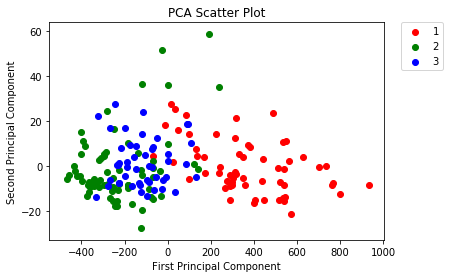

In [5]:
# Principal Component Analysis
myPCA = PCA(n_components = 2)
X_PCA = myPCA.fit_transform(X)

# Explained variance ratio
print ("Variance retention using 2 components: " + 
       str((np.sum(myPCA.fit(X).explained_variance_ratio_))*100) + " %")

# Plot PCA
colors = ['red', 'green', 'blue']

for i in range(len(colors)):
    xPlot = X_PCA[:, 0][y == i+1]
    yPlot = X_PCA[:, 1][y == i+1]
    plt.scatter(xPlot, yPlot, c=colors[i])
    plt.legend(targetNames, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("PCA Scatter Plot")
plt.show()

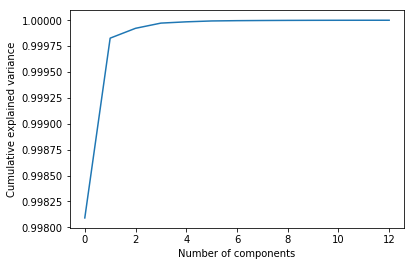

In [6]:
plt.plot(np.cumsum(PCA().fit(X).explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
plt.show()

As we can see in the graph above, 2 components are enough for PCA representation as it is retaining **99,98 % of the variance of the data.**

> QUESTION 3: Repeat the experiments performed in class.

The experiments performed in class are described in the **STEPS 2-7 of the analysis workflow showed below.**

## STEP 2: split data into Train, Test

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called **overfitting**. To avoid it, it is common practice when performing a supervised machine learning experiment to **hold out part of the available data as a test set XTest, yTest ** and be used only at the end of the data analysis. [[1]](http://scikit-learn.org/stable/modules/cross_validation.html)

For the splitting CV method ``` StratifiedShuffleSplit ``` (indicating 1 split) has been chosen for this task: it shuffles the dataset assuring the same proportion of samples per class in both Train and Test splits. The sizes chosen for Train-Test splits have been 70%-30% by chosing ```test_size = 0.3``` when calling the method. Additionally, by setting an integer for ```random_state``` attribute we are indicating a seed used by the random number generator for performing the splits with the aim of having the same split from now on in the exercise and compare the operations performed in the different sections in the same way.

In [7]:
## Split the data into Train, Test sets

myStratifiedShuffleSplit = StratifiedShuffleSplit(1, 0.3, random_state = 42)

for train_index, test_index in myStratifiedShuffleSplit.split(X, y):
    XTrain = X[train_index,:]
    XTest = X[test_index,:]
    yTrain = y[train_index]
    yTest = y[test_index]

# Sizes of each data split
print("Number of samples and dimensions for XTrain: " +str(XTrain.shape))
print("Number of labels for yTrain: " +str(yTrain.shape))
print("Number of samples and dimensions for XTest: " +str(XTest.shape))
print("Number of labels for yTest: " +str(yTest.shape))

Number of samples and dimensions for XTrain: (124L, 13L)
Number of labels for yTrain: (124L,)
Number of samples and dimensions for XTest: (54L, 13L)
Number of labels for yTest: (54L,)


## STEP 3: select a model

For this task model used is **k Nearest Neighbors (kNN)** which is a model used for **classification.** The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. The number of neighbors (hyperparameter for kNN) can be a user-defined constant. [[2]](http://scikit-learn.org/stable/modules/neighbors.html#neighbors)

In [8]:
myModel = KNeighborsClassifier()

## STEP 4: obtain best estimator hyper-parameters using GridSearch cross-validation

When evaluating different hyperparameters for the estimator there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally, and consequently knowledge about the test set can “leak” into the model. To solve this problem, another part of the dataset can be held out as a so-called **validation set**: training proceeds on the training set, then evaluation is done on the validation set, and if it is successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, there are two problems: (1) Number of samples which can be used for learning the model is drastically reduced; and (2) the results can depend on a particular random choice for the pair of (train, validation) sets: here it comes **generalization error**, which is a measure of how accurately an algorithm is able to predict outcome values for previously unseen data. 

A solution to these problems is a procedure called **cross-validation (CV)**. A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. [[3]](http://scikit-learn.org/stable/modules/cross_validation.html). The 3 main methods for CV studied in class are **(Stratified)KFold**, **(Stratified)ShuffleSplit** and **LeaveOneOut**. In this first attempt we are using **KFold CV** method.

The optimal hyperparameters for kNN classifier will be obtained using **GridSearch CV** method, which fits the model for every combination of hyper-parameters desired (several number of neighbors) and applies the desired CV over **XTrain, yTrain** sets that we obtained in STEP 2. 

In this first attempt,  ```weights```  parameter for kNN has been set as ```uniform``` , this mean that all points in each neighborhood are weighted equally.

In [9]:
#Function for running GridSearchCV

def runMyGridSearchCV(myModel, myParamGrid, myCV, XGrid, yGrid):
    
    myGridSearchCV = GridSearchCV(myModel, 
                              myParamGrid, 
                              cv = myCV,
                              verbose = 2, 
                              return_train_score = True)
    
    # Fit the grid
    myGridSearchCV.fit(XGrid, yGrid)
    
    # Display scores
    gridScores = pd.DataFrame(myGridSearchCV.cv_results_)
    display(gridScores)

    # BEST ESTIMATOR
    myBestModel = myGridSearchCV.best_estimator_
    print ("Best estimator: " + str(myBestModel))
    print ("Best grid cross-validation score: " + str(myGridSearchCV.best_score_))
            
    return myBestModel

In [10]:
# Run GridSearchCV with the desired CV
XGrid = XTrain
yGrid = yTrain
kVals = range(1, 80, 1)
myParamGrid = {'n_neighbors': kVals,
               'weights': ['uniform']}
myCV1 = KFold(n_splits = 10, random_state = 42)

# Run GridSearch CV for the given inputs
myBestModel1 = runMyGridSearchCV(myModel, myParamGrid, myCV1, XGrid, yGrid)

Fitting 10 folds for each of 79 candidates, totalling 790 fits
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] .

[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .

[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=34, weights=uniform, total=   0.0s
[CV] n_neighbors=34, weights=uniform .................................
[CV] .................. n_neighbors=34, weights=uniform, total=   0.0s
[CV] n_neighbors=34, weights=uniform .................................
[CV] .................. n_neighbors=34, weights=uniform, total=   0.0s
[CV] n_neighbors=34, weights=uniform .................................
[CV] .................. n_neighbors=34, weights=uniform, total=   0.0s
[CV] n_neighbors=34, weights=uniform .................................
[CV] .................. n_neighbors=34, weights=uniform, total=   0.0s
[CV] n_neighbors=35, weights=uniform .................................
[CV] .................. n_neighbors=35, weights=uniform, total=   0.0s
[CV] n_neighbors=35, weights=uniform .................................
[CV] .................. n_neighbors=35, weights=uniform, total=   0.0s
[CV] n_neighbors=35, weights=uniform .................................
[CV] .

[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=41, weights=uniform .................................
[CV] .................. n_neighbors=41, weights=uniform, total=   0.0s
[CV] n_neighbors=41, weights=uniform .................................
[CV] .................. n_neighbors=41, weights=uniform, total=   0.0s
[CV] n_neighbors=41, weights=uniform .................................
[CV] .................. n_neighbors=41, weights=uniform, total=   0.0s
[CV] n_neighbors=41, weights=uniform .................................
[CV] .................. n_neighbors=41, weights=uniform, total=   0.0s
[CV] n_neighbors=41, weights=uniform .................................
[CV] .................. n_neighbors=41, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n_neighbors=47, weights=uniform .................................
[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n_neighbors=47, weights=uniform .................................
[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n_neighbors=47, weights=uniform .................................
[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n_neighbors=47, weights=uniform .................................
[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n_neighbors=48, weights=uniform .................................
[CV] .................. n_neighbors=48, weights=uniform, total=   0.0s
[CV] n_neighbors=48, weights=uniform .................................
[CV] .................. n_neighbors=48, weights=uniform, total=   0.0s
[CV] n_neighbors=48, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=53, weights=uniform, total=   0.0s
[CV] n_neighbors=53, weights=uniform .................................
[CV] .................. n_neighbors=53, weights=uniform, total=   0.0s
[CV] n_neighbors=53, weights=uniform .................................
[CV] .................. n_neighbors=53, weights=uniform, total=   0.0s
[CV] n_neighbors=53, weights=uniform .................................
[CV] .................. n_neighbors=53, weights=uniform, total=   0.0s
[CV] n_neighbors=53, weights=uniform .................................
[CV] .................. n_neighbors=53, weights=uniform, total=   0.0s
[CV] n_neighbors=54, weights=uniform .................................
[CV] .................. n_neighbors=54, weights=uniform, total=   0.0s
[CV] n_neighbors=54, weights=uniform .................................
[CV] .................. n_neighbors=54, weights=uniform, total=   0.0s
[CV] n_neighbors=54, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n_neighbors=59, weights=uniform .................................
[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n_neighbors=59, weights=uniform .................................
[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n_neighbors=59, weights=uniform .................................
[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n_neighbors=59, weights=uniform .................................
[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n_neighbors=59, weights=uniform .................................
[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n_neighbors=60, weights=uniform .................................
[CV] .................. n_neighbors=60, weights=uniform, total=   0.0s
[CV] n_neighbors=60, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=66, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .

[Parallel(n_jobs=1)]: Done 790 out of 790 | elapsed:   13.8s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,param_weights,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.0031,0.0042,0.725806,1.000000,1,uniform,"{u'n_neighbors': 1, u'weights': u'uniform'}",2,0.769231,1.000000,...,0.500000,1.000000,0.666667,1.000000,0.750000,1.000000,0.001513,2.400003e-03,0.116752,0.000000
1,0.0016,0.0025,0.693548,0.845874,2,uniform,"{u'n_neighbors': 2, u'weights': u'uniform'}",36,0.692308,0.837838,...,0.500000,0.866071,0.666667,0.848214,0.583333,0.839286,0.000490,8.062265e-04,0.130088,0.013174
2,0.0017,0.0029,0.717742,0.849453,3,uniform,"{u'n_neighbors': 3, u'weights': u'uniform'}",4,0.692308,0.846847,...,0.750000,0.866071,0.666667,0.848214,0.583333,0.848214,0.000458,2.071243e-03,0.109248,0.015449
3,0.0020,0.0021,0.741935,0.825298,4,uniform,"{u'n_neighbors': 4, u'weights': u'uniform'}",1,0.615385,0.819820,...,0.666667,0.830357,0.750000,0.830357,0.916667,0.812500,0.000447,3.000101e-04,0.138627,0.012412
4,0.0016,0.0144,0.709677,0.794828,5,uniform,"{u'n_neighbors': 5, u'weights': u'uniform'}",16,0.846154,0.783784,...,0.666667,0.821429,0.666667,0.803571,0.666667,0.758929,0.000490,3.686789e-02,0.119567,0.020325
5,0.0016,0.0022,0.709677,0.784065,6,uniform,"{u'n_neighbors': 6, u'weights': u'uniform'}",16,0.769231,0.765766,...,0.666667,0.812500,0.750000,0.803571,0.750000,0.750000,0.000490,3.999949e-04,0.084018,0.024349
6,0.0015,0.0021,0.717742,0.775097,7,uniform,"{u'n_neighbors': 7, u'weights': u'uniform'}",4,0.769231,0.765766,...,0.750000,0.794643,0.750000,0.785714,0.750000,0.758929,0.000671,3.000021e-04,0.086241,0.020118
7,0.0015,0.0022,0.669355,0.769691,8,uniform,"{u'n_neighbors': 8, u'weights': u'uniform'}",56,0.692308,0.756757,...,0.666667,0.785714,0.750000,0.785714,0.583333,0.776786,0.000500,4.000187e-04,0.094622,0.012447
8,0.0012,0.0021,0.685484,0.761631,9,uniform,"{u'n_neighbors': 9, u'weights': u'uniform'}",45,0.692308,0.756757,...,0.583333,0.767857,0.750000,0.785714,0.666667,0.767857,0.000400,2.999306e-04,0.092771,0.015354
9,0.0016,0.0022,0.677419,0.732923,10,uniform,"{u'n_neighbors': 10, u'weights': u'uniform'}",51,0.692308,0.720721,...,0.583333,0.741071,0.666667,0.741071,0.666667,0.750000,0.000490,4.000425e-04,0.090404,0.022915


Best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')
Best grid cross-validation score: 0.741935483871


Result of GridSearch CV is that the optimal number of k for kNN is **4 neighbors**, which a **CV score of 74,2%**, **CV score standard deviation of 13,86%**, **train score of 82,52%** and **train score standard deviation of 1,24%**. 

Here we can perform a first evaluation of **underfitting** or **overfitting** by plotting **validation curve**. This is representing **Training / CV score vs Model complexity** (represented here by the number of neighbors -lower k higher complexity and viceversa-):

In [11]:
# Function for plotting VALIDATION CURVE

def plot_validation_curve(myEstimator, X, y, myParamRange, myCV, yLower, yUpper):
    train_scores, test_scores = validation_curve(
    myEstimator, X, y, param_name="n_neighbors", param_range=myParamRange,
    cv=myCV, scoring="accuracy", n_jobs=1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with kNN")
    plt.xlabel("k")
    plt.ylabel("Score")
    plt.ylim(yLower, yUpper)
    lw = 2
    plt.semilogx(kVals, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(kVals, train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(kVals, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(kVals, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

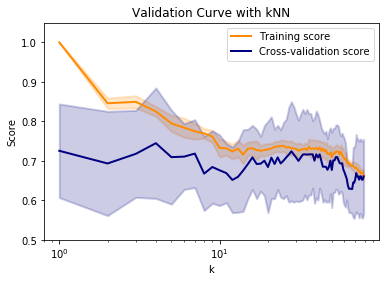

In [12]:
plot_validation_curve(myModel, XTrain, yTrain, kVals, myCV1, 0.5, 1.05)

Notes: Source code for plotting the curve from sklearn [[4]](http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html). This curve can be also represented plotting **Error vs Model complexity** (instead of score). 

**Below 4 neighbors** (which GridSearch gave as optimal), there are lower scores together with high training scores, situation could be overfitting. **Above 4 neighbors**, CV scores decrease too as well as training ones, situation could be underfitting. So 4 neighbors seem to be in fact the best option, despite the CV score is not very high.

To check the behavior of the model, after fitting (STEP 5) it is necessary to face the model to the unseen XTest (STEP 6) and different splits of the complete dataset (STEP 7).

But before let's check another options for model hyper-parameters and cross-validation methods (**Questions 4-7 from the task**), just in case we obtain a better score and a different optimal hyper-parameters configuration with them. In that case we will use it to  fit the model and continue with STEPS 4-7.

> QUESTION 4) Check the documentation for Scikit-learn library and configure the script for automatic validation (section 3) to allow that function GridSearchCV() uses Leave-one-out validation instead of K-fold. Describe which conclusions can be found from the mean scores of the cross validation and the test using a model with k neighbors with optimized k

This can be done by using  ```LeaveOneOut```  for  ```cv``` parameter within  ```GridSearchCV```. This method provides train/test indices to split data in train/test sets. Each sample is used once as a test set (singleton) while the remaining samples form the training set [[5]](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html). This method can be very time-consuming due to the high number of tests to be performed. 

In [13]:
myCV2 = LeaveOneOut()

# Run GridSearch CV for the given inputs
myBestModel2 = runMyGridSearchCV(myModel, myParamGrid, myCV2, XGrid, yGrid)

Fitting 124 folds for each of 79 candidates, totalling 9796 fits
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] .......

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] .

[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n

[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] .

[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n

[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] .

[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n

[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] .

[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .

[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .

[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .

[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .

[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .

[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .

[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .

[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .

[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .

[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=30, weights=uniform, total=   0.0s
[CV] n_neighbors=30, weights=uniform .................................
[CV] .................. n_neighbors=30, weights=uniform, total=   0.0s
[CV] n_neighbors=30, weights=uniform .................................
[CV] .................. n_neighbors=30, weights=uniform, total=   0.0s
[CV] n_neighbors=30, weights=uniform .................................
[CV] .................. n_neighbors=30, weights=uniform, total=   0.0s
[CV] n_neighbors=30, weights=uniform .................................
[CV] .................. n_neighbors=30, weights=uniform, total=   0.0s
[CV] n_neighbors=30, weights=uniform .................................
[CV] .................. n_neighbors=30, weights=uniform, total=   0.0s
[CV] n_neighbors=30, weights=uniform .................................
[CV] .................. n_neighbors=30, weights=uniform, total=   0.0s
[CV] n_neighbors=30, weights=uniform .................................
[CV] .

[CV] n_neighbors=30, weights=uniform .................................
[CV] .................. n_neighbors=30, weights=uniform, total=   0.0s
[CV] n_neighbors=30, weights=uniform .................................
[CV] .................. n_neighbors=30, weights=uniform, total=   0.0s
[CV] n_neighbors=30, weights=uniform .................................
[CV] .................. n_neighbors=30, weights=uniform, total=   0.0s
[CV] n_neighbors=30, weights=uniform .................................
[CV] .................. n_neighbors=30, weights=uniform, total=   0.0s
[CV] n_neighbors=30, weights=uniform .................................
[CV] .................. n_neighbors=30, weights=uniform, total=   0.0s
[CV] n_neighbors=30, weights=uniform .................................
[CV] .................. n_neighbors=30, weights=uniform, total=   0.0s
[CV] n_neighbors=30, weights=uniform .................................
[CV] .................. n_neighbors=30, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=31, weights=uniform .................................
[CV] .................. n_neighbors=31, weights=uniform, total=   0.0s
[CV] n_neighbors=31, weights=uniform .................................
[CV] .................. n_neighbors=31, weights=uniform, total=   0.0s
[CV] n_neighbors=31, weights=uniform .................................
[CV] .................. n_neighbors=31, weights=uniform, total=   0.0s
[CV] n_neighbors=31, weights=uniform .................................
[CV] .................. n_neighbors=31, weights=uniform, total=   0.0s
[CV] n_neighbors=31, weights=uniform .................................
[CV] .................. n_neighbors=31, weights=uniform, total=   0.0s
[CV] n_neighbors=31, weights=uniform .................................
[CV] .................. n_neighbors=31, weights=uniform, total=   0.0s
[CV] n_neighbors=31, weights=uniform .................................
[CV] .................. n_neighbors=31, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=31, weights=uniform, total=   0.0s
[CV] n_neighbors=31, weights=uniform .................................
[CV] .................. n_neighbors=31, weights=uniform, total=   0.0s
[CV] n_neighbors=31, weights=uniform .................................
[CV] .................. n_neighbors=31, weights=uniform, total=   0.0s
[CV] n_neighbors=31, weights=uniform .................................
[CV] .................. n_neighbors=31, weights=uniform, total=   0.0s
[CV] n_neighbors=31, weights=uniform .................................
[CV] .................. n_neighbors=31, weights=uniform, total=   0.0s
[CV] n_neighbors=31, weights=uniform .................................
[CV] .................. n_neighbors=31, weights=uniform, total=   0.0s
[CV] n_neighbors=31, weights=uniform .................................
[CV] .................. n_neighbors=31, weights=uniform, total=   0.0s
[CV] n_neighbors=31, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=32, weights=uniform, total=   0.0s
[CV] n_neighbors=32, weights=uniform .................................
[CV] .................. n_neighbors=32, weights=uniform, total=   0.0s
[CV] n_neighbors=32, weights=uniform .................................
[CV] .................. n_neighbors=32, weights=uniform, total=   0.0s
[CV] n_neighbors=32, weights=uniform .................................
[CV] .................. n_neighbors=32, weights=uniform, total=   0.0s
[CV] n_neighbors=32, weights=uniform .................................
[CV] .................. n_neighbors=32, weights=uniform, total=   0.0s
[CV] n_neighbors=32, weights=uniform .................................
[CV] .................. n_neighbors=32, weights=uniform, total=   0.0s
[CV] n_neighbors=32, weights=uniform .................................
[CV] .................. n_neighbors=32, weights=uniform, total=   0.0s
[CV] n_neighbors=32, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=32, weights=uniform, total=   0.0s
[CV] n_neighbors=32, weights=uniform .................................
[CV] .................. n_neighbors=32, weights=uniform, total=   0.0s
[CV] n_neighbors=33, weights=uniform .................................
[CV] .................. n_neighbors=33, weights=uniform, total=   0.0s
[CV] n_neighbors=33, weights=uniform .................................
[CV] .................. n_neighbors=33, weights=uniform, total=   0.0s
[CV] n_neighbors=33, weights=uniform .................................
[CV] .................. n_neighbors=33, weights=uniform, total=   0.0s
[CV] n_neighbors=33, weights=uniform .................................
[CV] .................. n_neighbors=33, weights=uniform, total=   0.0s
[CV] n_neighbors=33, weights=uniform .................................
[CV] .................. n_neighbors=33, weights=uniform, total=   0.0s
[CV] n_neighbors=33, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=33, weights=uniform, total=   0.0s
[CV] n_neighbors=33, weights=uniform .................................
[CV] .................. n_neighbors=33, weights=uniform, total=   0.0s
[CV] n_neighbors=33, weights=uniform .................................
[CV] .................. n_neighbors=33, weights=uniform, total=   0.0s
[CV] n_neighbors=33, weights=uniform .................................
[CV] .................. n_neighbors=33, weights=uniform, total=   0.0s
[CV] n_neighbors=33, weights=uniform .................................
[CV] .................. n_neighbors=33, weights=uniform, total=   0.0s
[CV] n_neighbors=33, weights=uniform .................................
[CV] .................. n_neighbors=33, weights=uniform, total=   0.0s
[CV] n_neighbors=33, weights=uniform .................................
[CV] .................. n_neighbors=33, weights=uniform, total=   0.0s
[CV] n_neighbors=33, weights=uniform .................................
[CV] .

[CV] n_neighbors=33, weights=uniform .................................
[CV] .................. n_neighbors=33, weights=uniform, total=   0.0s
[CV] n_neighbors=34, weights=uniform .................................
[CV] .................. n_neighbors=34, weights=uniform, total=   0.0s
[CV] n_neighbors=34, weights=uniform .................................
[CV] .................. n_neighbors=34, weights=uniform, total=   0.0s
[CV] n_neighbors=34, weights=uniform .................................
[CV] .................. n_neighbors=34, weights=uniform, total=   0.0s
[CV] n_neighbors=34, weights=uniform .................................
[CV] .................. n_neighbors=34, weights=uniform, total=   0.0s
[CV] n_neighbors=34, weights=uniform .................................
[CV] .................. n_neighbors=34, weights=uniform, total=   0.0s
[CV] n_neighbors=34, weights=uniform .................................
[CV] .................. n_neighbors=34, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=34, weights=uniform, total=   0.0s
[CV] n_neighbors=34, weights=uniform .................................
[CV] .................. n_neighbors=34, weights=uniform, total=   0.0s
[CV] n_neighbors=34, weights=uniform .................................
[CV] .................. n_neighbors=34, weights=uniform, total=   0.0s
[CV] n_neighbors=34, weights=uniform .................................
[CV] .................. n_neighbors=34, weights=uniform, total=   0.0s
[CV] n_neighbors=34, weights=uniform .................................
[CV] .................. n_neighbors=34, weights=uniform, total=   0.0s
[CV] n_neighbors=34, weights=uniform .................................
[CV] .................. n_neighbors=34, weights=uniform, total=   0.0s
[CV] n_neighbors=34, weights=uniform .................................
[CV] .................. n_neighbors=34, weights=uniform, total=   0.0s
[CV] n_neighbors=34, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=35, weights=uniform, total=   0.0s
[CV] n_neighbors=35, weights=uniform .................................
[CV] .................. n_neighbors=35, weights=uniform, total=   0.0s
[CV] n_neighbors=35, weights=uniform .................................
[CV] .................. n_neighbors=35, weights=uniform, total=   0.0s
[CV] n_neighbors=35, weights=uniform .................................
[CV] .................. n_neighbors=35, weights=uniform, total=   0.0s
[CV] n_neighbors=35, weights=uniform .................................
[CV] .................. n_neighbors=35, weights=uniform, total=   0.0s
[CV] n_neighbors=35, weights=uniform .................................
[CV] .................. n_neighbors=35, weights=uniform, total=   0.0s
[CV] n_neighbors=35, weights=uniform .................................
[CV] .................. n_neighbors=35, weights=uniform, total=   0.0s
[CV] n_neighbors=35, weights=uniform .................................
[CV] .

[CV] n_neighbors=35, weights=uniform .................................
[CV] .................. n_neighbors=35, weights=uniform, total=   0.0s
[CV] n_neighbors=35, weights=uniform .................................
[CV] .................. n_neighbors=35, weights=uniform, total=   0.0s
[CV] n_neighbors=35, weights=uniform .................................
[CV] .................. n_neighbors=35, weights=uniform, total=   0.0s
[CV] n_neighbors=35, weights=uniform .................................
[CV] .................. n_neighbors=35, weights=uniform, total=   0.0s
[CV] n_neighbors=35, weights=uniform .................................
[CV] .................. n_neighbors=35, weights=uniform, total=   0.0s
[CV] n_neighbors=35, weights=uniform .................................
[CV] .................. n_neighbors=35, weights=uniform, total=   0.0s
[CV] n_neighbors=35, weights=uniform .................................
[CV] .................. n_neighbors=35, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=36, weights=uniform, total=   0.0s
[CV] n_neighbors=36, weights=uniform .................................
[CV] .................. n_neighbors=36, weights=uniform, total=   0.0s
[CV] n_neighbors=36, weights=uniform .................................
[CV] .................. n_neighbors=36, weights=uniform, total=   0.0s
[CV] n_neighbors=36, weights=uniform .................................
[CV] .................. n_neighbors=36, weights=uniform, total=   0.0s
[CV] n_neighbors=36, weights=uniform .................................
[CV] .................. n_neighbors=36, weights=uniform, total=   0.0s
[CV] n_neighbors=36, weights=uniform .................................
[CV] .................. n_neighbors=36, weights=uniform, total=   0.0s
[CV] n_neighbors=36, weights=uniform .................................
[CV] .................. n_neighbors=36, weights=uniform, total=   0.0s
[CV] n_neighbors=36, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=36, weights=uniform, total=   0.0s
[CV] n_neighbors=36, weights=uniform .................................
[CV] .................. n_neighbors=36, weights=uniform, total=   0.0s
[CV] n_neighbors=36, weights=uniform .................................
[CV] .................. n_neighbors=36, weights=uniform, total=   0.0s
[CV] n_neighbors=36, weights=uniform .................................
[CV] .................. n_neighbors=36, weights=uniform, total=   0.0s
[CV] n_neighbors=36, weights=uniform .................................
[CV] .................. n_neighbors=36, weights=uniform, total=   0.0s
[CV] n_neighbors=36, weights=uniform .................................
[CV] .................. n_neighbors=36, weights=uniform, total=   0.0s
[CV] n_neighbors=36, weights=uniform .................................
[CV] .................. n_neighbors=36, weights=uniform, total=   0.0s
[CV] n_neighbors=36, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=37, weights=uniform, total=   0.0s
[CV] n_neighbors=37, weights=uniform .................................
[CV] .................. n_neighbors=37, weights=uniform, total=   0.0s
[CV] n_neighbors=37, weights=uniform .................................
[CV] .................. n_neighbors=37, weights=uniform, total=   0.0s
[CV] n_neighbors=37, weights=uniform .................................
[CV] .................. n_neighbors=37, weights=uniform, total=   0.0s
[CV] n_neighbors=37, weights=uniform .................................
[CV] .................. n_neighbors=37, weights=uniform, total=   0.0s
[CV] n_neighbors=37, weights=uniform .................................
[CV] .................. n_neighbors=37, weights=uniform, total=   0.0s
[CV] n_neighbors=37, weights=uniform .................................
[CV] .................. n_neighbors=37, weights=uniform, total=   0.0s
[CV] n_neighbors=37, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=37, weights=uniform, total=   0.0s
[CV] n_neighbors=37, weights=uniform .................................
[CV] .................. n_neighbors=37, weights=uniform, total=   0.0s
[CV] n_neighbors=37, weights=uniform .................................
[CV] .................. n_neighbors=37, weights=uniform, total=   0.0s
[CV] n_neighbors=37, weights=uniform .................................
[CV] .................. n_neighbors=37, weights=uniform, total=   0.0s
[CV] n_neighbors=37, weights=uniform .................................
[CV] .................. n_neighbors=37, weights=uniform, total=   0.0s
[CV] n_neighbors=37, weights=uniform .................................
[CV] .................. n_neighbors=37, weights=uniform, total=   0.0s
[CV] n_neighbors=37, weights=uniform .................................
[CV] .................. n_neighbors=37, weights=uniform, total=   0.0s
[CV] n_neighbors=37, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=38, weights=uniform, total=   0.0s
[CV] n_neighbors=38, weights=uniform .................................
[CV] .................. n_neighbors=38, weights=uniform, total=   0.0s
[CV] n_neighbors=38, weights=uniform .................................
[CV] .................. n_neighbors=38, weights=uniform, total=   0.0s
[CV] n_neighbors=38, weights=uniform .................................
[CV] .................. n_neighbors=38, weights=uniform, total=   0.0s
[CV] n_neighbors=38, weights=uniform .................................
[CV] .................. n_neighbors=38, weights=uniform, total=   0.0s
[CV] n_neighbors=38, weights=uniform .................................
[CV] .................. n_neighbors=38, weights=uniform, total=   0.0s
[CV] n_neighbors=38, weights=uniform .................................
[CV] .................. n_neighbors=38, weights=uniform, total=   0.0s
[CV] n_neighbors=38, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=38, weights=uniform, total=   0.0s
[CV] n_neighbors=38, weights=uniform .................................
[CV] .................. n_neighbors=38, weights=uniform, total=   0.0s
[CV] n_neighbors=38, weights=uniform .................................
[CV] .................. n_neighbors=38, weights=uniform, total=   0.0s
[CV] n_neighbors=38, weights=uniform .................................
[CV] .................. n_neighbors=38, weights=uniform, total=   0.0s
[CV] n_neighbors=38, weights=uniform .................................
[CV] .................. n_neighbors=38, weights=uniform, total=   0.0s
[CV] n_neighbors=38, weights=uniform .................................
[CV] .................. n_neighbors=38, weights=uniform, total=   0.0s
[CV] n_neighbors=38, weights=uniform .................................
[CV] .................. n_neighbors=38, weights=uniform, total=   0.0s
[CV] n_neighbors=38, weights=uniform .................................
[CV] .

[CV] n_neighbors=39, weights=uniform .................................
[CV] .................. n_neighbors=39, weights=uniform, total=   0.0s
[CV] n_neighbors=39, weights=uniform .................................
[CV] .................. n_neighbors=39, weights=uniform, total=   0.0s
[CV] n_neighbors=39, weights=uniform .................................
[CV] .................. n_neighbors=39, weights=uniform, total=   0.0s
[CV] n_neighbors=39, weights=uniform .................................
[CV] .................. n_neighbors=39, weights=uniform, total=   0.0s
[CV] n_neighbors=39, weights=uniform .................................
[CV] .................. n_neighbors=39, weights=uniform, total=   0.0s
[CV] n_neighbors=39, weights=uniform .................................
[CV] .................. n_neighbors=39, weights=uniform, total=   0.0s
[CV] n_neighbors=39, weights=uniform .................................
[CV] .................. n_neighbors=39, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=39, weights=uniform, total=   0.0s
[CV] n_neighbors=39, weights=uniform .................................
[CV] .................. n_neighbors=39, weights=uniform, total=   0.0s
[CV] n_neighbors=39, weights=uniform .................................
[CV] .................. n_neighbors=39, weights=uniform, total=   0.0s
[CV] n_neighbors=39, weights=uniform .................................
[CV] .................. n_neighbors=39, weights=uniform, total=   0.0s
[CV] n_neighbors=39, weights=uniform .................................
[CV] .................. n_neighbors=39, weights=uniform, total=   0.0s
[CV] n_neighbors=39, weights=uniform .................................
[CV] .................. n_neighbors=39, weights=uniform, total=   0.0s
[CV] n_neighbors=39, weights=uniform .................................
[CV] .................. n_neighbors=39, weights=uniform, total=   0.0s
[CV] n_neighbors=39, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=41, weights=uniform, total=   0.0s
[CV] n_neighbors=41, weights=uniform .................................
[CV] .................. n_neighbors=41, weights=uniform, total=   0.0s
[CV] n_neighbors=41, weights=uniform .................................
[CV] .................. n_neighbors=41, weights=uniform, total=   0.0s
[CV] n_neighbors=41, weights=uniform .................................
[CV] .................. n_neighbors=41, weights=uniform, total=   0.0s
[CV] n_neighbors=41, weights=uniform .................................
[CV] .................. n_neighbors=41, weights=uniform, total=   0.0s
[CV] n_neighbors=41, weights=uniform .................................
[CV] .................. n_neighbors=41, weights=uniform, total=   0.0s
[CV] n_neighbors=41, weights=uniform .................................
[CV] .................. n_neighbors=41, weights=uniform, total=   0.0s
[CV] n_neighbors=41, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=41, weights=uniform, total=   0.0s
[CV] n_neighbors=41, weights=uniform .................................
[CV] .................. n_neighbors=41, weights=uniform, total=   0.0s
[CV] n_neighbors=41, weights=uniform .................................
[CV] .................. n_neighbors=41, weights=uniform, total=   0.0s
[CV] n_neighbors=41, weights=uniform .................................
[CV] .................. n_neighbors=41, weights=uniform, total=   0.0s
[CV] n_neighbors=41, weights=uniform .................................
[CV] .................. n_neighbors=41, weights=uniform, total=   0.0s
[CV] n_neighbors=41, weights=uniform .................................
[CV] .................. n_neighbors=41, weights=uniform, total=   0.0s
[CV] n_neighbors=41, weights=uniform .................................
[CV] .................. n_neighbors=41, weights=uniform, total=   0.0s
[CV] n_neighbors=41, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=42, weights=uniform, total=   0.0s
[CV] n_neighbors=42, weights=uniform .................................
[CV] .................. n_neighbors=42, weights=uniform, total=   0.0s
[CV] n_neighbors=42, weights=uniform .................................
[CV] .................. n_neighbors=42, weights=uniform, total=   0.0s
[CV] n_neighbors=42, weights=uniform .................................
[CV] .................. n_neighbors=42, weights=uniform, total=   0.0s
[CV] n_neighbors=42, weights=uniform .................................
[CV] .................. n_neighbors=42, weights=uniform, total=   0.0s
[CV] n_neighbors=42, weights=uniform .................................
[CV] .................. n_neighbors=42, weights=uniform, total=   0.0s
[CV] n_neighbors=42, weights=uniform .................................
[CV] .................. n_neighbors=42, weights=uniform, total=   0.0s
[CV] n_neighbors=42, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=42, weights=uniform, total=   0.0s
[CV] n_neighbors=42, weights=uniform .................................
[CV] .................. n_neighbors=42, weights=uniform, total=   0.0s
[CV] n_neighbors=42, weights=uniform .................................
[CV] .................. n_neighbors=42, weights=uniform, total=   0.0s
[CV] n_neighbors=42, weights=uniform .................................
[CV] .................. n_neighbors=42, weights=uniform, total=   0.0s
[CV] n_neighbors=42, weights=uniform .................................
[CV] .................. n_neighbors=42, weights=uniform, total=   0.0s
[CV] n_neighbors=43, weights=uniform .................................
[CV] .................. n_neighbors=43, weights=uniform, total=   0.0s
[CV] n_neighbors=43, weights=uniform .................................
[CV] .................. n_neighbors=43, weights=uniform, total=   0.0s
[CV] n_neighbors=43, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=43, weights=uniform, total=   0.0s
[CV] n_neighbors=43, weights=uniform .................................
[CV] .................. n_neighbors=43, weights=uniform, total=   0.0s
[CV] n_neighbors=43, weights=uniform .................................
[CV] .................. n_neighbors=43, weights=uniform, total=   0.0s
[CV] n_neighbors=43, weights=uniform .................................
[CV] .................. n_neighbors=43, weights=uniform, total=   0.0s
[CV] n_neighbors=43, weights=uniform .................................
[CV] .................. n_neighbors=43, weights=uniform, total=   0.0s
[CV] n_neighbors=43, weights=uniform .................................
[CV] .................. n_neighbors=43, weights=uniform, total=   0.0s
[CV] n_neighbors=43, weights=uniform .................................
[CV] .................. n_neighbors=43, weights=uniform, total=   0.0s
[CV] n_neighbors=43, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=44, weights=uniform, total=   0.0s
[CV] n_neighbors=44, weights=uniform .................................
[CV] .................. n_neighbors=44, weights=uniform, total=   0.0s
[CV] n_neighbors=44, weights=uniform .................................
[CV] .................. n_neighbors=44, weights=uniform, total=   0.0s
[CV] n_neighbors=44, weights=uniform .................................
[CV] .................. n_neighbors=44, weights=uniform, total=   0.0s
[CV] n_neighbors=44, weights=uniform .................................
[CV] .................. n_neighbors=44, weights=uniform, total=   0.0s
[CV] n_neighbors=44, weights=uniform .................................
[CV] .................. n_neighbors=44, weights=uniform, total=   0.0s
[CV] n_neighbors=44, weights=uniform .................................
[CV] .................. n_neighbors=44, weights=uniform, total=   0.0s
[CV] n_neighbors=44, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=44, weights=uniform, total=   0.0s
[CV] n_neighbors=44, weights=uniform .................................
[CV] .................. n_neighbors=44, weights=uniform, total=   0.0s
[CV] n_neighbors=44, weights=uniform .................................
[CV] .................. n_neighbors=44, weights=uniform, total=   0.0s
[CV] n_neighbors=44, weights=uniform .................................
[CV] .................. n_neighbors=44, weights=uniform, total=   0.0s
[CV] n_neighbors=44, weights=uniform .................................
[CV] .................. n_neighbors=44, weights=uniform, total=   0.0s
[CV] n_neighbors=44, weights=uniform .................................
[CV] .................. n_neighbors=44, weights=uniform, total=   0.0s
[CV] n_neighbors=44, weights=uniform .................................
[CV] .................. n_neighbors=44, weights=uniform, total=   0.0s
[CV] n_neighbors=44, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=45, weights=uniform, total=   0.0s
[CV] n_neighbors=45, weights=uniform .................................
[CV] .................. n_neighbors=45, weights=uniform, total=   0.0s
[CV] n_neighbors=45, weights=uniform .................................
[CV] .................. n_neighbors=45, weights=uniform, total=   0.0s
[CV] n_neighbors=45, weights=uniform .................................
[CV] .................. n_neighbors=45, weights=uniform, total=   0.0s
[CV] n_neighbors=45, weights=uniform .................................
[CV] .................. n_neighbors=45, weights=uniform, total=   0.0s
[CV] n_neighbors=45, weights=uniform .................................
[CV] .................. n_neighbors=45, weights=uniform, total=   0.0s
[CV] n_neighbors=45, weights=uniform .................................
[CV] .................. n_neighbors=45, weights=uniform, total=   0.0s
[CV] n_neighbors=45, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n_neighbors=46, weights=uniform .................................
[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n_neighbors=46, weights=uniform .................................
[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n_neighbors=46, weights=uniform .................................
[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n_neighbors=46, weights=uniform .................................
[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n_neighbors=46, weights=uniform .................................
[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n_neighbors=46, weights=uniform .................................
[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n_neighbors=46, weights=uniform .................................
[CV] .

[CV] n_neighbors=46, weights=uniform .................................
[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n_neighbors=46, weights=uniform .................................
[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n_neighbors=46, weights=uniform .................................
[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n_neighbors=46, weights=uniform .................................
[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n_neighbors=46, weights=uniform .................................
[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n_neighbors=46, weights=uniform .................................
[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n_neighbors=46, weights=uniform .................................
[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n_neighbors=47, weights=uniform .................................
[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n_neighbors=47, weights=uniform .................................
[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n_neighbors=47, weights=uniform .................................
[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n_neighbors=47, weights=uniform .................................
[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n_neighbors=47, weights=uniform .................................
[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n_neighbors=47, weights=uniform .................................
[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n_neighbors=47, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n_neighbors=47, weights=uniform .................................
[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n_neighbors=47, weights=uniform .................................
[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n_neighbors=47, weights=uniform .................................
[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n_neighbors=47, weights=uniform .................................
[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n_neighbors=47, weights=uniform .................................
[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n_neighbors=47, weights=uniform .................................
[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n_neighbors=47, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=48, weights=uniform, total=   0.0s
[CV] n_neighbors=48, weights=uniform .................................
[CV] .................. n_neighbors=48, weights=uniform, total=   0.0s
[CV] n_neighbors=48, weights=uniform .................................
[CV] .................. n_neighbors=48, weights=uniform, total=   0.0s
[CV] n_neighbors=48, weights=uniform .................................
[CV] .................. n_neighbors=48, weights=uniform, total=   0.0s
[CV] n_neighbors=48, weights=uniform .................................
[CV] .................. n_neighbors=48, weights=uniform, total=   0.0s
[CV] n_neighbors=48, weights=uniform .................................
[CV] .................. n_neighbors=48, weights=uniform, total=   0.0s
[CV] n_neighbors=48, weights=uniform .................................
[CV] .................. n_neighbors=48, weights=uniform, total=   0.0s
[CV] n_neighbors=48, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=48, weights=uniform, total=   0.0s
[CV] n_neighbors=48, weights=uniform .................................
[CV] .................. n_neighbors=48, weights=uniform, total=   0.0s
[CV] n_neighbors=48, weights=uniform .................................
[CV] .................. n_neighbors=48, weights=uniform, total=   0.0s
[CV] n_neighbors=48, weights=uniform .................................
[CV] .................. n_neighbors=48, weights=uniform, total=   0.0s
[CV] n_neighbors=48, weights=uniform .................................
[CV] .................. n_neighbors=48, weights=uniform, total=   0.0s
[CV] n_neighbors=48, weights=uniform .................................
[CV] .................. n_neighbors=48, weights=uniform, total=   0.0s
[CV] n_neighbors=48, weights=uniform .................................
[CV] .................. n_neighbors=48, weights=uniform, total=   0.0s
[CV] n_neighbors=48, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=49, weights=uniform, total=   0.0s
[CV] n_neighbors=49, weights=uniform .................................
[CV] .................. n_neighbors=49, weights=uniform, total=   0.0s
[CV] n_neighbors=49, weights=uniform .................................
[CV] .................. n_neighbors=49, weights=uniform, total=   0.0s
[CV] n_neighbors=49, weights=uniform .................................
[CV] .................. n_neighbors=49, weights=uniform, total=   0.0s
[CV] n_neighbors=49, weights=uniform .................................
[CV] .................. n_neighbors=49, weights=uniform, total=   0.0s
[CV] n_neighbors=49, weights=uniform .................................
[CV] .................. n_neighbors=49, weights=uniform, total=   0.0s
[CV] n_neighbors=49, weights=uniform .................................
[CV] .................. n_neighbors=49, weights=uniform, total=   0.0s
[CV] n_neighbors=49, weights=uniform .................................
[CV] .

[CV] n_neighbors=49, weights=uniform .................................
[CV] .................. n_neighbors=49, weights=uniform, total=   0.0s
[CV] n_neighbors=49, weights=uniform .................................
[CV] .................. n_neighbors=49, weights=uniform, total=   0.0s
[CV] n_neighbors=49, weights=uniform .................................
[CV] .................. n_neighbors=49, weights=uniform, total=   0.0s
[CV] n_neighbors=49, weights=uniform .................................
[CV] .................. n_neighbors=49, weights=uniform, total=   0.0s
[CV] n_neighbors=49, weights=uniform .................................
[CV] .................. n_neighbors=49, weights=uniform, total=   0.0s
[CV] n_neighbors=49, weights=uniform .................................
[CV] .................. n_neighbors=49, weights=uniform, total=   0.0s
[CV] n_neighbors=49, weights=uniform .................................
[CV] .................. n_neighbors=49, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=50, weights=uniform, total=   0.0s
[CV] n_neighbors=50, weights=uniform .................................
[CV] .................. n_neighbors=50, weights=uniform, total=   0.0s
[CV] n_neighbors=50, weights=uniform .................................
[CV] .................. n_neighbors=50, weights=uniform, total=   0.0s
[CV] n_neighbors=50, weights=uniform .................................
[CV] .................. n_neighbors=50, weights=uniform, total=   0.0s
[CV] n_neighbors=50, weights=uniform .................................
[CV] .................. n_neighbors=50, weights=uniform, total=   0.0s
[CV] n_neighbors=50, weights=uniform .................................
[CV] .................. n_neighbors=50, weights=uniform, total=   0.0s
[CV] n_neighbors=50, weights=uniform .................................
[CV] .................. n_neighbors=50, weights=uniform, total=   0.0s
[CV] n_neighbors=50, weights=uniform .................................
[CV] .

[CV] n_neighbors=50, weights=uniform .................................
[CV] .................. n_neighbors=50, weights=uniform, total=   0.0s
[CV] n_neighbors=50, weights=uniform .................................
[CV] .................. n_neighbors=50, weights=uniform, total=   0.0s
[CV] n_neighbors=50, weights=uniform .................................
[CV] .................. n_neighbors=50, weights=uniform, total=   0.0s
[CV] n_neighbors=50, weights=uniform .................................
[CV] .................. n_neighbors=50, weights=uniform, total=   0.0s
[CV] n_neighbors=50, weights=uniform .................................
[CV] .................. n_neighbors=50, weights=uniform, total=   0.0s
[CV] n_neighbors=50, weights=uniform .................................
[CV] .................. n_neighbors=50, weights=uniform, total=   0.0s
[CV] n_neighbors=50, weights=uniform .................................
[CV] .................. n_neighbors=50, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=51, weights=uniform, total=   0.0s
[CV] n_neighbors=51, weights=uniform .................................
[CV] .................. n_neighbors=51, weights=uniform, total=   0.0s
[CV] n_neighbors=51, weights=uniform .................................
[CV] .................. n_neighbors=51, weights=uniform, total=   0.0s
[CV] n_neighbors=51, weights=uniform .................................
[CV] .................. n_neighbors=51, weights=uniform, total=   0.0s
[CV] n_neighbors=51, weights=uniform .................................
[CV] .................. n_neighbors=51, weights=uniform, total=   0.0s
[CV] n_neighbors=51, weights=uniform .................................
[CV] .................. n_neighbors=51, weights=uniform, total=   0.0s
[CV] n_neighbors=51, weights=uniform .................................
[CV] .................. n_neighbors=51, weights=uniform, total=   0.0s
[CV] n_neighbors=51, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=51, weights=uniform, total=   0.0s
[CV] n_neighbors=51, weights=uniform .................................
[CV] .................. n_neighbors=51, weights=uniform, total=   0.0s
[CV] n_neighbors=51, weights=uniform .................................
[CV] .................. n_neighbors=51, weights=uniform, total=   0.0s
[CV] n_neighbors=51, weights=uniform .................................
[CV] .................. n_neighbors=51, weights=uniform, total=   0.0s
[CV] n_neighbors=51, weights=uniform .................................
[CV] .................. n_neighbors=51, weights=uniform, total=   0.0s
[CV] n_neighbors=51, weights=uniform .................................
[CV] .................. n_neighbors=51, weights=uniform, total=   0.0s
[CV] n_neighbors=51, weights=uniform .................................
[CV] .................. n_neighbors=51, weights=uniform, total=   0.0s
[CV] n_neighbors=51, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .

[CV] n_neighbors=52, weights=uniform .................................
[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=53, weights=uniform .................................
[CV] .................. n_neighbors=53, weights=uniform, total=   0.0s
[CV] n_neighbors=53, weights=uniform .................................
[CV] .................. n_neighbors=53, weights=uniform, total=   0.0s
[CV] n_neighbors=53, weights=uniform .................................
[CV] .................. n_neighbors=53, weights=uniform, total=   0.0s
[CV] n_neighbors=53, weights=uniform .................................
[CV] .................. n_neighbors=53, weights=uniform, total=   0.0s
[CV] n_neighbors=53, weights=uniform .................................
[CV] .................. n_neighbors=53, weights=uniform, total=   0.0s
[CV] n_neighbors=53, weights=uniform .................................
[CV] .................. n_neighbors=53, weights=uniform, total=   0.0s
[CV] n_neighbors=53, weights=uniform .................................
[CV] .................. n_neighbors=53, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=53, weights=uniform, total=   0.0s
[CV] n_neighbors=53, weights=uniform .................................
[CV] .................. n_neighbors=53, weights=uniform, total=   0.0s
[CV] n_neighbors=53, weights=uniform .................................
[CV] .................. n_neighbors=53, weights=uniform, total=   0.0s
[CV] n_neighbors=53, weights=uniform .................................
[CV] .................. n_neighbors=53, weights=uniform, total=   0.0s
[CV] n_neighbors=53, weights=uniform .................................
[CV] .................. n_neighbors=53, weights=uniform, total=   0.0s
[CV] n_neighbors=53, weights=uniform .................................
[CV] .................. n_neighbors=53, weights=uniform, total=   0.0s
[CV] n_neighbors=53, weights=uniform .................................
[CV] .................. n_neighbors=53, weights=uniform, total=   0.0s
[CV] n_neighbors=53, weights=uniform .................................
[CV] .

[CV] n_neighbors=54, weights=uniform .................................
[CV] .................. n_neighbors=54, weights=uniform, total=   0.0s
[CV] n_neighbors=54, weights=uniform .................................
[CV] .................. n_neighbors=54, weights=uniform, total=   0.0s
[CV] n_neighbors=54, weights=uniform .................................
[CV] .................. n_neighbors=54, weights=uniform, total=   0.0s
[CV] n_neighbors=54, weights=uniform .................................
[CV] .................. n_neighbors=54, weights=uniform, total=   0.0s
[CV] n_neighbors=54, weights=uniform .................................
[CV] .................. n_neighbors=54, weights=uniform, total=   0.0s
[CV] n_neighbors=54, weights=uniform .................................
[CV] .................. n_neighbors=54, weights=uniform, total=   0.0s
[CV] n_neighbors=54, weights=uniform .................................
[CV] .................. n_neighbors=54, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=54, weights=uniform, total=   0.0s
[CV] n_neighbors=54, weights=uniform .................................
[CV] .................. n_neighbors=54, weights=uniform, total=   0.0s
[CV] n_neighbors=54, weights=uniform .................................
[CV] .................. n_neighbors=54, weights=uniform, total=   0.0s
[CV] n_neighbors=54, weights=uniform .................................
[CV] .................. n_neighbors=54, weights=uniform, total=   0.0s
[CV] n_neighbors=54, weights=uniform .................................
[CV] .................. n_neighbors=54, weights=uniform, total=   0.0s
[CV] n_neighbors=54, weights=uniform .................................
[CV] .................. n_neighbors=54, weights=uniform, total=   0.0s
[CV] n_neighbors=54, weights=uniform .................................
[CV] .................. n_neighbors=54, weights=uniform, total=   0.0s
[CV] n_neighbors=54, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=55, weights=uniform, total=   0.0s
[CV] n_neighbors=55, weights=uniform .................................
[CV] .................. n_neighbors=55, weights=uniform, total=   0.0s
[CV] n_neighbors=55, weights=uniform .................................
[CV] .................. n_neighbors=55, weights=uniform, total=   0.0s
[CV] n_neighbors=55, weights=uniform .................................
[CV] .................. n_neighbors=55, weights=uniform, total=   0.0s
[CV] n_neighbors=55, weights=uniform .................................
[CV] .................. n_neighbors=55, weights=uniform, total=   0.0s
[CV] n_neighbors=55, weights=uniform .................................
[CV] .................. n_neighbors=55, weights=uniform, total=   0.0s
[CV] n_neighbors=55, weights=uniform .................................
[CV] .................. n_neighbors=55, weights=uniform, total=   0.0s
[CV] n_neighbors=55, weights=uniform .................................
[CV] .

[CV] n_neighbors=55, weights=uniform .................................
[CV] .................. n_neighbors=55, weights=uniform, total=   0.0s
[CV] n_neighbors=55, weights=uniform .................................
[CV] .................. n_neighbors=55, weights=uniform, total=   0.0s
[CV] n_neighbors=55, weights=uniform .................................
[CV] .................. n_neighbors=55, weights=uniform, total=   0.0s
[CV] n_neighbors=55, weights=uniform .................................
[CV] .................. n_neighbors=55, weights=uniform, total=   0.0s
[CV] n_neighbors=55, weights=uniform .................................
[CV] .................. n_neighbors=55, weights=uniform, total=   0.0s
[CV] n_neighbors=55, weights=uniform .................................
[CV] .................. n_neighbors=55, weights=uniform, total=   0.0s
[CV] n_neighbors=55, weights=uniform .................................
[CV] .................. n_neighbors=55, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=56, weights=uniform, total=   0.0s
[CV] n_neighbors=56, weights=uniform .................................
[CV] .................. n_neighbors=56, weights=uniform, total=   0.0s
[CV] n_neighbors=56, weights=uniform .................................
[CV] .................. n_neighbors=56, weights=uniform, total=   0.0s
[CV] n_neighbors=56, weights=uniform .................................
[CV] .................. n_neighbors=56, weights=uniform, total=   0.0s
[CV] n_neighbors=56, weights=uniform .................................
[CV] .................. n_neighbors=56, weights=uniform, total=   0.0s
[CV] n_neighbors=56, weights=uniform .................................
[CV] .................. n_neighbors=56, weights=uniform, total=   0.0s
[CV] n_neighbors=56, weights=uniform .................................
[CV] .................. n_neighbors=56, weights=uniform, total=   0.0s
[CV] n_neighbors=56, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=56, weights=uniform, total=   0.0s
[CV] n_neighbors=56, weights=uniform .................................
[CV] .................. n_neighbors=56, weights=uniform, total=   0.0s
[CV] n_neighbors=56, weights=uniform .................................
[CV] .................. n_neighbors=56, weights=uniform, total=   0.0s
[CV] n_neighbors=56, weights=uniform .................................
[CV] .................. n_neighbors=56, weights=uniform, total=   0.0s
[CV] n_neighbors=56, weights=uniform .................................
[CV] .................. n_neighbors=56, weights=uniform, total=   0.0s
[CV] n_neighbors=56, weights=uniform .................................
[CV] .................. n_neighbors=56, weights=uniform, total=   0.0s
[CV] n_neighbors=56, weights=uniform .................................
[CV] .................. n_neighbors=56, weights=uniform, total=   0.0s
[CV] n_neighbors=56, weights=uniform .................................
[CV] .

[CV] n_neighbors=57, weights=uniform .................................
[CV] .................. n_neighbors=57, weights=uniform, total=   0.0s
[CV] n_neighbors=57, weights=uniform .................................
[CV] .................. n_neighbors=57, weights=uniform, total=   0.0s
[CV] n_neighbors=57, weights=uniform .................................
[CV] .................. n_neighbors=57, weights=uniform, total=   0.0s
[CV] n_neighbors=57, weights=uniform .................................
[CV] .................. n_neighbors=57, weights=uniform, total=   0.0s
[CV] n_neighbors=57, weights=uniform .................................
[CV] .................. n_neighbors=57, weights=uniform, total=   0.0s
[CV] n_neighbors=57, weights=uniform .................................
[CV] .................. n_neighbors=57, weights=uniform, total=   0.0s
[CV] n_neighbors=57, weights=uniform .................................
[CV] .................. n_neighbors=57, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=57, weights=uniform .................................
[CV] .................. n_neighbors=57, weights=uniform, total=   0.0s
[CV] n_neighbors=57, weights=uniform .................................
[CV] .................. n_neighbors=57, weights=uniform, total=   0.0s
[CV] n_neighbors=57, weights=uniform .................................
[CV] .................. n_neighbors=57, weights=uniform, total=   0.0s
[CV] n_neighbors=57, weights=uniform .................................
[CV] .................. n_neighbors=57, weights=uniform, total=   0.0s
[CV] n_neighbors=57, weights=uniform .................................
[CV] .................. n_neighbors=57, weights=uniform, total=   0.0s
[CV] n_neighbors=57, weights=uniform .................................
[CV] .................. n_neighbors=57, weights=uniform, total=   0.0s
[CV] n_neighbors=57, weights=uniform .................................
[CV] .................. n_neighbors=57, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=58, weights=uniform .................................
[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n_neighbors=59, weights=uniform .................................
[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n_neighbors=59, weights=uniform .................................
[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n_neighbors=59, weights=uniform .................................
[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n_neighbors=59, weights=uniform .................................
[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n_neighbors=59, weights=uniform .................................
[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n_neighbors=59, weights=uniform .................................
[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n_neighbors=59, weights=uniform .................................
[CV] .

[CV] n_neighbors=59, weights=uniform .................................
[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n_neighbors=59, weights=uniform .................................
[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n_neighbors=59, weights=uniform .................................
[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n_neighbors=59, weights=uniform .................................
[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n_neighbors=59, weights=uniform .................................
[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n_neighbors=59, weights=uniform .................................
[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n_neighbors=59, weights=uniform .................................
[CV] .................. n_neighbors=59, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=60, weights=uniform .................................
[CV] .................. n_neighbors=60, weights=uniform, total=   0.0s
[CV] n_neighbors=60, weights=uniform .................................
[CV] .................. n_neighbors=60, weights=uniform, total=   0.0s
[CV] n_neighbors=60, weights=uniform .................................
[CV] .................. n_neighbors=60, weights=uniform, total=   0.0s
[CV] n_neighbors=60, weights=uniform .................................
[CV] .................. n_neighbors=60, weights=uniform, total=   0.0s
[CV] n_neighbors=60, weights=uniform .................................
[CV] .................. n_neighbors=60, weights=uniform, total=   0.0s
[CV] n_neighbors=60, weights=uniform .................................
[CV] .................. n_neighbors=60, weights=uniform, total=   0.0s
[CV] n_neighbors=60, weights=uniform .................................
[CV] .................. n_neighbors=60, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=60, weights=uniform .................................
[CV] .................. n_neighbors=60, weights=uniform, total=   0.0s
[CV] n_neighbors=60, weights=uniform .................................
[CV] .................. n_neighbors=60, weights=uniform, total=   0.0s
[CV] n_neighbors=60, weights=uniform .................................
[CV] .................. n_neighbors=60, weights=uniform, total=   0.0s
[CV] n_neighbors=60, weights=uniform .................................
[CV] .................. n_neighbors=60, weights=uniform, total=   0.0s
[CV] n_neighbors=60, weights=uniform .................................
[CV] .................. n_neighbors=60, weights=uniform, total=   0.0s
[CV] n_neighbors=60, weights=uniform .................................
[CV] .................. n_neighbors=60, weights=uniform, total=   0.0s
[CV] n_neighbors=60, weights=uniform .................................
[CV] .................. n_neighbors=60, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=61, weights=uniform, total=   0.0s
[CV] n_neighbors=61, weights=uniform .................................
[CV] .................. n_neighbors=61, weights=uniform, total=   0.0s
[CV] n_neighbors=61, weights=uniform .................................
[CV] .................. n_neighbors=61, weights=uniform, total=   0.0s
[CV] n_neighbors=61, weights=uniform .................................
[CV] .................. n_neighbors=61, weights=uniform, total=   0.0s
[CV] n_neighbors=61, weights=uniform .................................
[CV] .................. n_neighbors=61, weights=uniform, total=   0.0s
[CV] n_neighbors=61, weights=uniform .................................
[CV] .................. n_neighbors=61, weights=uniform, total=   0.0s
[CV] n_neighbors=61, weights=uniform .................................
[CV] .................. n_neighbors=61, weights=uniform, total=   0.0s
[CV] n_neighbors=61, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=61, weights=uniform, total=   0.0s
[CV] n_neighbors=61, weights=uniform .................................
[CV] .................. n_neighbors=61, weights=uniform, total=   0.0s
[CV] n_neighbors=61, weights=uniform .................................
[CV] .................. n_neighbors=61, weights=uniform, total=   0.0s
[CV] n_neighbors=61, weights=uniform .................................
[CV] .................. n_neighbors=61, weights=uniform, total=   0.0s
[CV] n_neighbors=61, weights=uniform .................................
[CV] .................. n_neighbors=61, weights=uniform, total=   0.0s
[CV] n_neighbors=61, weights=uniform .................................
[CV] .................. n_neighbors=61, weights=uniform, total=   0.0s
[CV] n_neighbors=61, weights=uniform .................................
[CV] .................. n_neighbors=61, weights=uniform, total=   0.0s
[CV] n_neighbors=61, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=62, weights=uniform, total=   0.0s
[CV] n_neighbors=62, weights=uniform .................................
[CV] .................. n_neighbors=62, weights=uniform, total=   0.0s
[CV] n_neighbors=62, weights=uniform .................................
[CV] .................. n_neighbors=62, weights=uniform, total=   0.0s
[CV] n_neighbors=62, weights=uniform .................................
[CV] .................. n_neighbors=62, weights=uniform, total=   0.0s
[CV] n_neighbors=62, weights=uniform .................................
[CV] .................. n_neighbors=62, weights=uniform, total=   0.0s
[CV] n_neighbors=62, weights=uniform .................................
[CV] .................. n_neighbors=62, weights=uniform, total=   0.0s
[CV] n_neighbors=62, weights=uniform .................................
[CV] .................. n_neighbors=62, weights=uniform, total=   0.0s
[CV] n_neighbors=62, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=62, weights=uniform, total=   0.0s
[CV] n_neighbors=63, weights=uniform .................................
[CV] .................. n_neighbors=63, weights=uniform, total=   0.0s
[CV] n_neighbors=63, weights=uniform .................................
[CV] .................. n_neighbors=63, weights=uniform, total=   0.0s
[CV] n_neighbors=63, weights=uniform .................................
[CV] .................. n_neighbors=63, weights=uniform, total=   0.0s
[CV] n_neighbors=63, weights=uniform .................................
[CV] .................. n_neighbors=63, weights=uniform, total=   0.0s
[CV] n_neighbors=63, weights=uniform .................................
[CV] .................. n_neighbors=63, weights=uniform, total=   0.0s
[CV] n_neighbors=63, weights=uniform .................................
[CV] .................. n_neighbors=63, weights=uniform, total=   0.0s
[CV] n_neighbors=63, weights=uniform .................................
[CV] .

[CV] n_neighbors=63, weights=uniform .................................
[CV] .................. n_neighbors=63, weights=uniform, total=   0.0s
[CV] n_neighbors=63, weights=uniform .................................
[CV] .................. n_neighbors=63, weights=uniform, total=   0.0s
[CV] n_neighbors=63, weights=uniform .................................
[CV] .................. n_neighbors=63, weights=uniform, total=   0.0s
[CV] n_neighbors=63, weights=uniform .................................
[CV] .................. n_neighbors=63, weights=uniform, total=   0.0s
[CV] n_neighbors=63, weights=uniform .................................
[CV] .................. n_neighbors=63, weights=uniform, total=   0.0s
[CV] n_neighbors=63, weights=uniform .................................
[CV] .................. n_neighbors=63, weights=uniform, total=   0.0s
[CV] n_neighbors=63, weights=uniform .................................
[CV] .................. n_neighbors=63, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=64, weights=uniform .................................
[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=64, weights=uniform .................................
[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=64, weights=uniform .................................
[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=64, weights=uniform .................................
[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=64, weights=uniform .................................
[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=64, weights=uniform .................................
[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=64, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=64, weights=uniform .................................
[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=64, weights=uniform .................................
[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=64, weights=uniform .................................
[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=64, weights=uniform .................................
[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=64, weights=uniform .................................
[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=64, weights=uniform .................................
[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=64, weights=uniform .................................
[CV] .

[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=66, weights=uniform, total=   0.0s
[CV] n_neighbors=66, weights=uniform .................................
[CV] .................. n_neighbors=66, weights=uniform, total=   0.0s
[CV] n_neighbors=66, weights=uniform .................................
[CV] .................. n_neighbors=66, weights=uniform, total=   0.0s
[CV] n_neighbors=66, weights=uniform .................................
[CV] .................. n_neighbors=66, weights=uniform, total=   0.0s
[CV] n_neighbors=66, weights=uniform .................................
[CV] .................. n_neighbors=66, weights=uniform, total=   0.0s
[CV] n_neighbors=66, weights=uniform .................................
[CV] .................. n_neighbors=66, weights=uniform, total=   0.0s
[CV] n_neighbors=66, weights=uniform .................................
[CV] .................. n_neighbors=66, weights=uniform, total=   0.0s
[CV] n_neighbors=66, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=66, weights=uniform, total=   0.0s
[CV] n_neighbors=66, weights=uniform .................................
[CV] .................. n_neighbors=66, weights=uniform, total=   0.0s
[CV] n_neighbors=66, weights=uniform .................................
[CV] .................. n_neighbors=66, weights=uniform, total=   0.0s
[CV] n_neighbors=66, weights=uniform .................................
[CV] .................. n_neighbors=66, weights=uniform, total=   0.0s
[CV] n_neighbors=66, weights=uniform .................................
[CV] .................. n_neighbors=66, weights=uniform, total=   0.0s
[CV] n_neighbors=66, weights=uniform .................................
[CV] .................. n_neighbors=66, weights=uniform, total=   0.0s
[CV] n_neighbors=66, weights=uniform .................................
[CV] .................. n_neighbors=66, weights=uniform, total=   0.0s
[CV] n_neighbors=66, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=67, weights=uniform, total=   0.0s
[CV] n_neighbors=67, weights=uniform .................................
[CV] .................. n_neighbors=67, weights=uniform, total=   0.0s
[CV] n_neighbors=67, weights=uniform .................................
[CV] .................. n_neighbors=67, weights=uniform, total=   0.0s
[CV] n_neighbors=67, weights=uniform .................................
[CV] .................. n_neighbors=67, weights=uniform, total=   0.0s
[CV] n_neighbors=67, weights=uniform .................................
[CV] .................. n_neighbors=67, weights=uniform, total=   0.0s
[CV] n_neighbors=67, weights=uniform .................................
[CV] .................. n_neighbors=67, weights=uniform, total=   0.0s
[CV] n_neighbors=67, weights=uniform .................................
[CV] .................. n_neighbors=67, weights=uniform, total=   0.0s
[CV] n_neighbors=67, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=67, weights=uniform, total=   0.0s
[CV] n_neighbors=67, weights=uniform .................................
[CV] .................. n_neighbors=67, weights=uniform, total=   0.0s
[CV] n_neighbors=67, weights=uniform .................................
[CV] .................. n_neighbors=67, weights=uniform, total=   0.0s
[CV] n_neighbors=67, weights=uniform .................................
[CV] .................. n_neighbors=67, weights=uniform, total=   0.0s
[CV] n_neighbors=67, weights=uniform .................................
[CV] .................. n_neighbors=67, weights=uniform, total=   0.0s
[CV] n_neighbors=67, weights=uniform .................................
[CV] .................. n_neighbors=67, weights=uniform, total=   0.0s
[CV] n_neighbors=67, weights=uniform .................................
[CV] .................. n_neighbors=67, weights=uniform, total=   0.0s
[CV] n_neighbors=67, weights=uniform .................................
[CV] .

[CV] n_neighbors=68, weights=uniform .................................
[CV] .................. n_neighbors=68, weights=uniform, total=   0.0s
[CV] n_neighbors=68, weights=uniform .................................
[CV] .................. n_neighbors=68, weights=uniform, total=   0.0s
[CV] n_neighbors=68, weights=uniform .................................
[CV] .................. n_neighbors=68, weights=uniform, total=   0.0s
[CV] n_neighbors=68, weights=uniform .................................
[CV] .................. n_neighbors=68, weights=uniform, total=   0.0s
[CV] n_neighbors=68, weights=uniform .................................
[CV] .................. n_neighbors=68, weights=uniform, total=   0.0s
[CV] n_neighbors=68, weights=uniform .................................
[CV] .................. n_neighbors=68, weights=uniform, total=   0.0s
[CV] n_neighbors=68, weights=uniform .................................
[CV] .................. n_neighbors=68, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=69, weights=uniform .................................
[CV] .................. n_neighbors=69, weights=uniform, total=   0.0s
[CV] n_neighbors=69, weights=uniform .................................
[CV] .................. n_neighbors=69, weights=uniform, total=   0.0s
[CV] n_neighbors=69, weights=uniform .................................
[CV] .................. n_neighbors=69, weights=uniform, total=   0.0s
[CV] n_neighbors=69, weights=uniform .................................
[CV] .................. n_neighbors=69, weights=uniform, total=   0.0s
[CV] n_neighbors=69, weights=uniform .................................
[CV] .................. n_neighbors=69, weights=uniform, total=   0.0s
[CV] n_neighbors=69, weights=uniform .................................
[CV] .................. n_neighbors=69, weights=uniform, total=   0.0s
[CV] n_neighbors=69, weights=uniform .................................
[CV] .................. n_neighbors=69, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=69, weights=uniform .................................
[CV] .................. n_neighbors=69, weights=uniform, total=   0.0s
[CV] n_neighbors=69, weights=uniform .................................
[CV] .................. n_neighbors=69, weights=uniform, total=   0.0s
[CV] n_neighbors=69, weights=uniform .................................
[CV] .................. n_neighbors=69, weights=uniform, total=   0.0s
[CV] n_neighbors=69, weights=uniform .................................
[CV] .................. n_neighbors=69, weights=uniform, total=   0.0s
[CV] n_neighbors=69, weights=uniform .................................
[CV] .................. n_neighbors=69, weights=uniform, total=   0.0s
[CV] n_neighbors=69, weights=uniform .................................
[CV] .................. n_neighbors=69, weights=uniform, total=   0.0s
[CV] n_neighbors=69, weights=uniform .................................
[CV] .................. n_neighbors=69, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=70, weights=uniform .................................
[CV] .................. n_neighbors=70, weights=uniform, total=   0.0s
[CV] n_neighbors=70, weights=uniform .................................
[CV] .................. n_neighbors=70, weights=uniform, total=   0.0s
[CV] n_neighbors=70, weights=uniform .................................
[CV] .................. n_neighbors=70, weights=uniform, total=   0.0s
[CV] n_neighbors=70, weights=uniform .................................
[CV] .................. n_neighbors=70, weights=uniform, total=   0.0s
[CV] n_neighbors=70, weights=uniform .................................
[CV] .................. n_neighbors=70, weights=uniform, total=   0.0s
[CV] n_neighbors=70, weights=uniform .................................
[CV] .................. n_neighbors=70, weights=uniform, total=   0.0s
[CV] n_neighbors=70, weights=uniform .................................
[CV] .................. n_neighbors=70, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=70, weights=uniform, total=   0.0s
[CV] n_neighbors=70, weights=uniform .................................
[CV] .................. n_neighbors=70, weights=uniform, total=   0.0s
[CV] n_neighbors=70, weights=uniform .................................
[CV] .................. n_neighbors=70, weights=uniform, total=   0.0s
[CV] n_neighbors=70, weights=uniform .................................
[CV] .................. n_neighbors=70, weights=uniform, total=   0.0s
[CV] n_neighbors=70, weights=uniform .................................
[CV] .................. n_neighbors=70, weights=uniform, total=   0.0s
[CV] n_neighbors=70, weights=uniform .................................
[CV] .................. n_neighbors=70, weights=uniform, total=   0.0s
[CV] n_neighbors=70, weights=uniform .................................
[CV] .................. n_neighbors=70, weights=uniform, total=   0.0s
[CV] n_neighbors=70, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=71, weights=uniform, total=   0.0s
[CV] n_neighbors=71, weights=uniform .................................
[CV] .................. n_neighbors=71, weights=uniform, total=   0.0s
[CV] n_neighbors=71, weights=uniform .................................
[CV] .................. n_neighbors=71, weights=uniform, total=   0.0s
[CV] n_neighbors=71, weights=uniform .................................
[CV] .................. n_neighbors=71, weights=uniform, total=   0.0s
[CV] n_neighbors=71, weights=uniform .................................
[CV] .................. n_neighbors=71, weights=uniform, total=   0.0s
[CV] n_neighbors=71, weights=uniform .................................
[CV] .................. n_neighbors=71, weights=uniform, total=   0.0s
[CV] n_neighbors=71, weights=uniform .................................
[CV] .................. n_neighbors=71, weights=uniform, total=   0.0s
[CV] n_neighbors=71, weights=uniform .................................
[CV] .

[CV] n_neighbors=71, weights=uniform .................................
[CV] .................. n_neighbors=71, weights=uniform, total=   0.0s
[CV] n_neighbors=71, weights=uniform .................................
[CV] .................. n_neighbors=71, weights=uniform, total=   0.0s
[CV] n_neighbors=71, weights=uniform .................................
[CV] .................. n_neighbors=71, weights=uniform, total=   0.0s
[CV] n_neighbors=71, weights=uniform .................................
[CV] .................. n_neighbors=71, weights=uniform, total=   0.0s
[CV] n_neighbors=71, weights=uniform .................................
[CV] .................. n_neighbors=71, weights=uniform, total=   0.0s
[CV] n_neighbors=71, weights=uniform .................................
[CV] .................. n_neighbors=71, weights=uniform, total=   0.0s
[CV] n_neighbors=71, weights=uniform .................................
[CV] .................. n_neighbors=71, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=72, weights=uniform, total=   0.0s
[CV] n_neighbors=72, weights=uniform .................................
[CV] .................. n_neighbors=72, weights=uniform, total=   0.0s
[CV] n_neighbors=72, weights=uniform .................................
[CV] .................. n_neighbors=72, weights=uniform, total=   0.0s
[CV] n_neighbors=72, weights=uniform .................................
[CV] .................. n_neighbors=72, weights=uniform, total=   0.0s
[CV] n_neighbors=72, weights=uniform .................................
[CV] .................. n_neighbors=72, weights=uniform, total=   0.0s
[CV] n_neighbors=72, weights=uniform .................................
[CV] .................. n_neighbors=72, weights=uniform, total=   0.0s
[CV] n_neighbors=72, weights=uniform .................................
[CV] .................. n_neighbors=72, weights=uniform, total=   0.0s
[CV] n_neighbors=72, weights=uniform .................................
[CV] .

[CV] n_neighbors=72, weights=uniform .................................
[CV] .................. n_neighbors=72, weights=uniform, total=   0.0s
[CV] n_neighbors=72, weights=uniform .................................
[CV] .................. n_neighbors=72, weights=uniform, total=   0.0s
[CV] n_neighbors=72, weights=uniform .................................
[CV] .................. n_neighbors=72, weights=uniform, total=   0.0s
[CV] n_neighbors=72, weights=uniform .................................
[CV] .................. n_neighbors=72, weights=uniform, total=   0.0s
[CV] n_neighbors=72, weights=uniform .................................
[CV] .................. n_neighbors=72, weights=uniform, total=   0.0s
[CV] n_neighbors=72, weights=uniform .................................
[CV] .................. n_neighbors=72, weights=uniform, total=   0.0s
[CV] n_neighbors=72, weights=uniform .................................
[CV] .................. n_neighbors=72, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=73, weights=uniform, total=   0.0s
[CV] n_neighbors=73, weights=uniform .................................
[CV] .................. n_neighbors=73, weights=uniform, total=   0.0s
[CV] n_neighbors=73, weights=uniform .................................
[CV] .................. n_neighbors=73, weights=uniform, total=   0.0s
[CV] n_neighbors=73, weights=uniform .................................
[CV] .................. n_neighbors=73, weights=uniform, total=   0.0s
[CV] n_neighbors=73, weights=uniform .................................
[CV] .................. n_neighbors=73, weights=uniform, total=   0.0s
[CV] n_neighbors=73, weights=uniform .................................
[CV] .................. n_neighbors=73, weights=uniform, total=   0.0s
[CV] n_neighbors=73, weights=uniform .................................
[CV] .................. n_neighbors=73, weights=uniform, total=   0.0s
[CV] n_neighbors=73, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=73, weights=uniform, total=   0.0s
[CV] n_neighbors=73, weights=uniform .................................
[CV] .................. n_neighbors=73, weights=uniform, total=   0.0s
[CV] n_neighbors=73, weights=uniform .................................
[CV] .................. n_neighbors=73, weights=uniform, total=   0.0s
[CV] n_neighbors=73, weights=uniform .................................
[CV] .................. n_neighbors=73, weights=uniform, total=   0.0s
[CV] n_neighbors=73, weights=uniform .................................
[CV] .................. n_neighbors=73, weights=uniform, total=   0.0s
[CV] n_neighbors=73, weights=uniform .................................
[CV] .................. n_neighbors=73, weights=uniform, total=   0.0s
[CV] n_neighbors=73, weights=uniform .................................
[CV] .................. n_neighbors=73, weights=uniform, total=   0.0s
[CV] n_neighbors=73, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=74, weights=uniform, total=   0.0s
[CV] n_neighbors=74, weights=uniform .................................
[CV] .................. n_neighbors=74, weights=uniform, total=   0.0s
[CV] n_neighbors=74, weights=uniform .................................
[CV] .................. n_neighbors=74, weights=uniform, total=   0.0s
[CV] n_neighbors=74, weights=uniform .................................
[CV] .................. n_neighbors=74, weights=uniform, total=   0.0s
[CV] n_neighbors=74, weights=uniform .................................
[CV] .................. n_neighbors=74, weights=uniform, total=   0.0s
[CV] n_neighbors=74, weights=uniform .................................
[CV] .................. n_neighbors=74, weights=uniform, total=   0.0s
[CV] n_neighbors=74, weights=uniform .................................
[CV] .................. n_neighbors=74, weights=uniform, total=   0.0s
[CV] n_neighbors=74, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=74, weights=uniform, total=   0.0s
[CV] n_neighbors=74, weights=uniform .................................
[CV] .................. n_neighbors=74, weights=uniform, total=   0.0s
[CV] n_neighbors=74, weights=uniform .................................
[CV] .................. n_neighbors=74, weights=uniform, total=   0.0s
[CV] n_neighbors=74, weights=uniform .................................
[CV] .................. n_neighbors=74, weights=uniform, total=   0.0s
[CV] n_neighbors=74, weights=uniform .................................
[CV] .................. n_neighbors=74, weights=uniform, total=   0.0s
[CV] n_neighbors=74, weights=uniform .................................
[CV] .................. n_neighbors=74, weights=uniform, total=   0.0s
[CV] n_neighbors=74, weights=uniform .................................
[CV] .................. n_neighbors=74, weights=uniform, total=   0.0s
[CV] n_neighbors=74, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=75, weights=uniform, total=   0.0s
[CV] n_neighbors=75, weights=uniform .................................
[CV] .................. n_neighbors=75, weights=uniform, total=   0.0s
[CV] n_neighbors=75, weights=uniform .................................
[CV] .................. n_neighbors=75, weights=uniform, total=   0.0s
[CV] n_neighbors=75, weights=uniform .................................
[CV] .................. n_neighbors=75, weights=uniform, total=   0.0s
[CV] n_neighbors=75, weights=uniform .................................
[CV] .................. n_neighbors=75, weights=uniform, total=   0.0s
[CV] n_neighbors=75, weights=uniform .................................
[CV] .................. n_neighbors=75, weights=uniform, total=   0.0s
[CV] n_neighbors=75, weights=uniform .................................
[CV] .................. n_neighbors=75, weights=uniform, total=   0.0s
[CV] n_neighbors=75, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=75, weights=uniform, total=   0.0s
[CV] n_neighbors=75, weights=uniform .................................
[CV] .................. n_neighbors=75, weights=uniform, total=   0.0s
[CV] n_neighbors=75, weights=uniform .................................
[CV] .................. n_neighbors=75, weights=uniform, total=   0.0s
[CV] n_neighbors=75, weights=uniform .................................
[CV] .................. n_neighbors=75, weights=uniform, total=   0.0s
[CV] n_neighbors=75, weights=uniform .................................
[CV] .................. n_neighbors=75, weights=uniform, total=   0.0s
[CV] n_neighbors=75, weights=uniform .................................
[CV] .................. n_neighbors=75, weights=uniform, total=   0.0s
[CV] n_neighbors=75, weights=uniform .................................
[CV] .................. n_neighbors=75, weights=uniform, total=   0.0s
[CV] n_neighbors=75, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=76, weights=uniform, total=   0.0s
[CV] n_neighbors=76, weights=uniform .................................
[CV] .................. n_neighbors=76, weights=uniform, total=   0.0s
[CV] n_neighbors=76, weights=uniform .................................
[CV] .................. n_neighbors=76, weights=uniform, total=   0.0s
[CV] n_neighbors=76, weights=uniform .................................
[CV] .................. n_neighbors=76, weights=uniform, total=   0.0s
[CV] n_neighbors=76, weights=uniform .................................
[CV] .................. n_neighbors=76, weights=uniform, total=   0.0s
[CV] n_neighbors=76, weights=uniform .................................
[CV] .................. n_neighbors=76, weights=uniform, total=   0.0s
[CV] n_neighbors=76, weights=uniform .................................
[CV] .................. n_neighbors=76, weights=uniform, total=   0.0s
[CV] n_neighbors=76, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=76, weights=uniform, total=   0.0s
[CV] n_neighbors=76, weights=uniform .................................
[CV] .................. n_neighbors=76, weights=uniform, total=   0.0s
[CV] n_neighbors=76, weights=uniform .................................
[CV] .................. n_neighbors=76, weights=uniform, total=   0.0s
[CV] n_neighbors=76, weights=uniform .................................
[CV] .................. n_neighbors=76, weights=uniform, total=   0.0s
[CV] n_neighbors=76, weights=uniform .................................
[CV] .................. n_neighbors=76, weights=uniform, total=   0.0s
[CV] n_neighbors=76, weights=uniform .................................
[CV] .................. n_neighbors=76, weights=uniform, total=   0.0s
[CV] n_neighbors=76, weights=uniform .................................
[CV] .................. n_neighbors=76, weights=uniform, total=   0.0s
[CV] n_neighbors=76, weights=uniform .................................
[CV] .

[CV] n_neighbors=77, weights=uniform .................................
[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .................. n_neighbors=77, weights=uniform, total=   0.0s
[CV] n_neighbors=77, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=78, weights=uniform, total=   0.0s
[CV] n_neighbors=78, weights=uniform .................................
[CV] .................. n_neighbors=78, weights=uniform, total=   0.0s
[CV] n_neighbors=78, weights=uniform .................................
[CV] .................. n_neighbors=78, weights=uniform, total=   0.0s
[CV] n_neighbors=78, weights=uniform .................................
[CV] .................. n_neighbors=78, weights=uniform, total=   0.0s
[CV] n_neighbors=78, weights=uniform .................................
[CV] .................. n_neighbors=78, weights=uniform, total=   0.0s
[CV] n_neighbors=78, weights=uniform .................................
[CV] .................. n_neighbors=78, weights=uniform, total=   0.0s
[CV] n_neighbors=78, weights=uniform .................................
[CV] .................. n_neighbors=78, weights=uniform, total=   0.0s
[CV] n_neighbors=78, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=78, weights=uniform, total=   0.0s
[CV] n_neighbors=78, weights=uniform .................................
[CV] .................. n_neighbors=78, weights=uniform, total=   0.0s
[CV] n_neighbors=79, weights=uniform .................................
[CV] .................. n_neighbors=79, weights=uniform, total=   0.0s
[CV] n_neighbors=79, weights=uniform .................................
[CV] .................. n_neighbors=79, weights=uniform, total=   0.0s
[CV] n_neighbors=79, weights=uniform .................................
[CV] .................. n_neighbors=79, weights=uniform, total=   0.0s
[CV] n_neighbors=79, weights=uniform .................................
[CV] .................. n_neighbors=79, weights=uniform, total=   0.0s
[CV] n_neighbors=79, weights=uniform .................................
[CV] .................. n_neighbors=79, weights=uniform, total=   0.0s
[CV] n_neighbors=79, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=79, weights=uniform, total=   0.0s
[CV] n_neighbors=79, weights=uniform .................................
[CV] .................. n_neighbors=79, weights=uniform, total=   0.0s
[CV] n_neighbors=79, weights=uniform .................................
[CV] .................. n_neighbors=79, weights=uniform, total=   0.0s
[CV] n_neighbors=79, weights=uniform .................................
[CV] .................. n_neighbors=79, weights=uniform, total=   0.0s
[CV] n_neighbors=79, weights=uniform .................................
[CV] .................. n_neighbors=79, weights=uniform, total=   0.0s
[CV] n_neighbors=79, weights=uniform .................................
[CV] .................. n_neighbors=79, weights=uniform, total=   0.0s
[CV] n_neighbors=79, weights=uniform .................................
[CV] .................. n_neighbors=79, weights=uniform, total=   0.0s
[CV] n_neighbors=79, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=79, weights=uniform, total=   0.0s
[CV] n_neighbors=79, weights=uniform .................................
[CV] .................. n_neighbors=79, weights=uniform, total=   0.0s
[CV] n_neighbors=79, weights=uniform .................................
[CV] .................. n_neighbors=79, weights=uniform, total=   0.0s


[Parallel(n_jobs=1)]: Done 9796 out of 9796 | elapsed:  2.7min finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,param_weights,params,rank_test_score,split0_test_score,split0_train_score,...,split98_test_score,split98_train_score,split99_test_score,split99_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.001605,0.002185,0.733871,1.000000,1,uniform,"{u'n_neighbors': 1, u'weights': u'uniform'}",4,1.0,1.000000,...,1.0,1.000000,0.0,1.000000,1.0,1.000000,0.000645,0.000529,0.441933,0.000000
1,0.001653,0.002435,0.693548,0.846643,2,uniform,"{u'n_neighbors': 2, u'weights': u'uniform'}",52,1.0,0.845528,...,0.0,0.837398,0.0,0.853659,1.0,0.845528,0.000648,0.001010,0.461020,0.004043
2,0.001556,0.002145,0.709677,0.854445,3,uniform,"{u'n_neighbors': 3, u'weights': u'uniform'}",26,1.0,0.853659,...,1.0,0.853659,0.0,0.853659,1.0,0.853659,0.000572,0.000759,0.453911,0.004431
3,0.001540,0.002169,0.741935,0.822908,4,uniform,"{u'n_neighbors': 4, u'weights': u'uniform'}",1,1.0,0.821138,...,1.0,0.821138,0.0,0.829268,1.0,0.821138,0.000559,0.000886,0.437570,0.004904
4,0.001629,0.002250,0.701613,0.805862,5,uniform,"{u'n_neighbors': 5, u'weights': u'uniform'}",40,1.0,0.804878,...,1.0,0.813008,0.0,0.813008,1.0,0.804878,0.000602,0.000655,0.457550,0.005223
5,0.001484,0.002048,0.709677,0.789798,6,uniform,"{u'n_neighbors': 6, u'weights': u'uniform'}",26,1.0,0.788618,...,1.0,0.796748,0.0,0.796748,1.0,0.788618,0.000546,0.000771,0.453911,0.004919
6,0.001548,0.002040,0.741935,0.774194,7,uniform,"{u'n_neighbors': 7, u'weights': u'uniform'}",1,1.0,0.772358,...,1.0,0.780488,0.0,0.780488,1.0,0.772358,0.000544,0.000482,0.437570,0.004237
7,0.001524,0.002105,0.701613,0.773538,8,uniform,"{u'n_neighbors': 8, u'weights': u'uniform'}",40,1.0,0.772358,...,0.0,0.764228,0.0,0.780488,1.0,0.772358,0.000560,0.000607,0.457550,0.005026
8,0.001589,0.002040,0.709677,0.773472,9,uniform,"{u'n_neighbors': 9, u'weights': u'uniform'}",26,1.0,0.772358,...,0.0,0.756098,0.0,0.788618,1.0,0.772358,0.000539,0.000447,0.453911,0.005592
9,0.001661,0.002113,0.701613,0.741149,10,uniform,"{u'n_neighbors': 10, u'weights': u'uniform'}",40,1.0,0.739837,...,0.0,0.739837,0.0,0.756098,1.0,0.739837,0.000506,0.000444,0.457550,0.005304


Best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')
Best grid cross-validation score: 0.741935483871


Results obtained using ``LeaveOneOut`` are similar in terms of CV score (74,2%) and train standard deviation. However, in this case **CV standard deviation is much higher than KFold** (43,75% vs 11,67%). Tran score is also a little bit worse than using KFold (77,42% vs 82,52%).

One possible explanation for the high standard deviation for LeaveOneOut is because the training sets in ``LeaveOneOut`` have more **overlap** and that makes the estimates from different folds more dependent than in  ``KFold``, and hence increases the overall variance [[6]](https://stats.stackexchange.com/questions/90902/why-is-leave-one-out-cross-validation-loocv-variance-about-the-mean-estimate-f/110537).

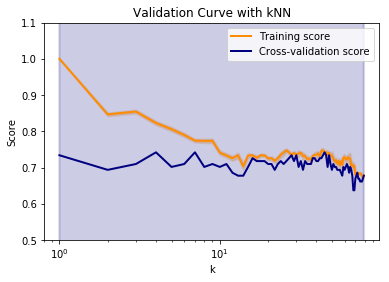

In [14]:
plot_validation_curve(myModel, XTrain, yTrain, kVals, myCV2, 0.5, 1.1)

Behavior of validation curve is similar here as in KFold except for the already discussed CV score standard deviation.

<mark>
<span style="font-size: 16px; color: black">
QUESTION 5) Think if it is necessary to stratify CV process analyzing the distribution of samples per class.
</span>
</mark>

Stratification makes sense specially with datasets where the number of samples per class is highly unbalanced, in order to preserve the relative class so that the model is capable or at least enough equipped to predict the outnumbered class (class with lesser points in number) [[7]](https://datascience.stackexchange.com/questions/16265/is-stratified-sampling-necessary-random-forest-python). In the case of this dataset, samples per class are not totaly balanced as showed in STEP 1 but neither in the extreme of highly unbalanced so the difference applying stratification should not be very high in this case:

In [15]:
myCV3 = StratifiedKFold(n_splits = 10, random_state = 42)

# Run GridSearch CV for the given inputs
myBestModel3 = runMyGridSearchCV(myModel, myParamGrid, myCV3, XGrid, yGrid)

Fitting 10 folds for each of 79 candidates, totalling 790 fits
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] .

[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=33, weights=uniform, total=   0.0s
[CV] n_neighbors=33, weights=uniform .................................
[CV] .................. n_neighbors=33, weights=uniform, total=   0.0s
[CV] n_neighbors=33, weights=uniform .................................
[CV] .................. n_neighbors=33, weights=uniform, total=   0.0s
[CV] n_neighbors=33, weights=uniform .................................
[CV] .................. n_neighbors=33, weights=uniform, total=   0.0s
[CV] n_neighbors=33, weights=uniform .................................
[CV] .................. n_neighbors=33, weights=uniform, total=   0.0s
[CV] n_neighbors=33, weights=uniform .................................
[CV] .................. n_neighbors=33, weights=uniform, total=   0.0s
[CV] n_neighbors=34, weights=uniform .................................
[CV] .................. n_neighbors=34, weights=uniform, total=   0.0s
[CV] n_neighbors=34, weights=uniform .................................
[CV] .

[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n_neighbors=40, weights=uniform .................................
[CV] .................. n_neighbors=40, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=46, weights=uniform .................................
[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n_neighbors=46, weights=uniform .................................
[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n_neighbors=46, weights=uniform .................................
[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n_neighbors=46, weights=uniform .................................
[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n_neighbors=46, weights=uniform .................................
[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n_neighbors=46, weights=uniform .................................
[CV] .................. n_neighbors=46, weights=uniform, total=   0.0s
[CV] n_neighbors=47, weights=uniform .................................
[CV] .................. n_neighbors=47, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .................. n_neighbors=52, weights=uniform, total=   0.0s
[CV] n_neighbors=52, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .................. n_neighbors=58, weights=uniform, total=   0.0s
[CV] n_neighbors=58, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=64, weights=uniform .................................
[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=64, weights=uniform .................................
[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=64, weights=uniform .................................
[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=64, weights=uniform .................................
[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=64, weights=uniform .................................
[CV] .................. n_neighbors=64, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .................. n_neighbors=65, weights=uniform, total=   0.0s
[CV] n_neighbors=65, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=71, weights=uniform, total=   0.0s
[CV] n_neighbors=71, weights=uniform .................................
[CV] .................. n_neighbors=71, weights=uniform, total=   0.0s
[CV] n_neighbors=71, weights=uniform .................................
[CV] .................. n_neighbors=71, weights=uniform, total=   0.0s
[CV] n_neighbors=71, weights=uniform .................................
[CV] .................. n_neighbors=71, weights=uniform, total=   0.0s
[CV] n_neighbors=72, weights=uniform .................................
[CV] .................. n_neighbors=72, weights=uniform, total=   0.0s
[CV] n_neighbors=72, weights=uniform .................................
[CV] .................. n_neighbors=72, weights=uniform, total=   0.0s
[CV] n_neighbors=72, weights=uniform .................................
[CV] .................. n_neighbors=72, weights=uniform, total=   0.0s
[CV] n_neighbors=72, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=78, weights=uniform, total=   0.0s
[CV] n_neighbors=78, weights=uniform .................................
[CV] .................. n_neighbors=78, weights=uniform, total=   0.0s
[CV] n_neighbors=78, weights=uniform .................................
[CV] .................. n_neighbors=78, weights=uniform, total=   0.0s
[CV] n_neighbors=78, weights=uniform .................................
[CV] .................. n_neighbors=78, weights=uniform, total=   0.0s
[CV] n_neighbors=78, weights=uniform .................................
[CV] .................. n_neighbors=78, weights=uniform, total=   0.0s
[CV] n_neighbors=78, weights=uniform .................................
[CV] .................. n_neighbors=78, weights=uniform, total=   0.0s
[CV] n_neighbors=78, weights=uniform .................................
[CV] .................. n_neighbors=78, weights=uniform, total=   0.0s
[CV] n_neighbors=78, weights=uniform .................................
[CV] .

[Parallel(n_jobs=1)]: Done 790 out of 790 | elapsed:   12.7s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,param_weights,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.0014,0.0021,0.717742,1.000000,1,uniform,"{u'n_neighbors': 1, u'weights': u'uniform'}",21,0.642857,1.000000,...,0.750000,1.000000,0.833333,1.000000,0.666667,1.000000,4.899014e-04,3.000101e-04,0.057718,0.000000
1,0.0018,0.0022,0.693548,0.846764,2,uniform,"{u'n_neighbors': 2, u'weights': u'uniform'}",56,0.571429,0.845455,...,0.666667,0.830357,0.750000,0.830357,0.666667,0.857143,6.000122e-04,5.999963e-04,0.096864,0.011712
2,0.0014,0.0020,0.709677,0.850376,3,uniform,"{u'n_neighbors': 3, u'weights': u'uniform'}",34,0.571429,0.854545,...,0.750000,0.839286,0.833333,0.821429,0.583333,0.866071,4.898625e-04,1.168008e-07,0.126937,0.017263
3,0.0013,0.0021,0.717742,0.823533,4,uniform,"{u'n_neighbors': 4, u'weights': u'uniform'}",21,0.500000,0.836364,...,0.833333,0.821429,0.916667,0.803571,0.833333,0.830357,4.582452e-04,2.999942e-04,0.137903,0.013160
4,0.0014,0.0025,0.701613,0.798420,5,uniform,"{u'n_neighbors': 5, u'weights': u'uniform'}",47,0.714286,0.800000,...,0.833333,0.812500,0.833333,0.785714,0.666667,0.785714,4.898819e-04,6.708962e-04,0.093744,0.018898
5,0.0016,0.0022,0.709677,0.784963,6,uniform,"{u'n_neighbors': 6, u'weights': u'uniform'}",34,0.642857,0.781818,...,0.833333,0.794643,0.916667,0.767857,0.750000,0.785714,6.632769e-04,5.999883e-04,0.131818,0.016720
6,0.0014,0.0021,0.701613,0.773323,7,uniform,"{u'n_neighbors': 7, u'weights': u'uniform'}",47,0.642857,0.781818,...,0.833333,0.776786,0.916667,0.758929,0.583333,0.767857,4.898527e-04,3.000021e-04,0.133408,0.012800
7,0.0014,0.0022,0.685484,0.763478,8,uniform,"{u'n_neighbors': 8, u'weights': u'uniform'}",65,0.571429,0.781818,...,0.750000,0.758929,0.833333,0.758929,0.666667,0.776786,4.898625e-04,4.000187e-04,0.116519,0.012674
8,0.0015,0.0023,0.701613,0.760783,9,uniform,"{u'n_neighbors': 9, u'weights': u'uniform'}",47,0.571429,0.781818,...,0.750000,0.750000,0.833333,0.758929,0.750000,0.776786,4.999638e-04,4.582712e-04,0.129390,0.011385
9,0.0012,0.0023,0.685484,0.730264,10,uniform,"{u'n_neighbors': 10, u'weights': u'uniform'}",65,0.571429,0.736364,...,0.750000,0.741071,0.750000,0.723214,0.750000,0.741071,3.999472e-04,4.582556e-04,0.127128,0.019642


Best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=23, p=2,
           weights='uniform')
Best grid cross-validation score: 0.75


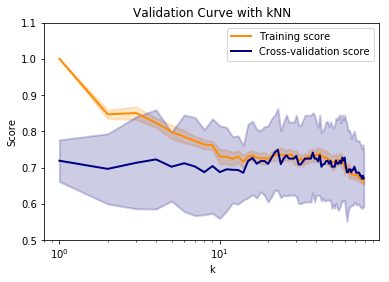

In [36]:
plot_validation_curve(myModel, XTrain, yTrain, kVals, myCV3, 0.5, 1.1)

In terms of scores and standard deviation results here are very similar to KFold. However, optimal number of neighbors is suggested here as 23. Even if it is the highest CV score, maybe it is not the best option because if we check 4 neighbors (as it was suggested by KFold) CV score is very similar and training score much higher, improving the situation of underfitting that seems to have 23 neighbors.

**Sumary** after applying ``KFold``, ``LeaveOneOut`` and ``StratifiedKFold`` with ``uniform`` weights:

| CV method        | CV score      | CV std   | Train score  | Train std| Best k | Weights |
| ---------------- | -------------:| --------:|-------------:| --------:| ------:| -------:|
| KFold            |0.7419        | 0.1386   | 0.8252      | 0.0124   |   4   | uniform |
| LeaveOneOut      | 0.7419        | 0.4375   | 0.7742       | 0.00522 |   4    | uniform |
| StratifiedKFold  | 0.75       | 0.1128    | 0.7365       |0.0149 |   23    | uniform |

We will continue introducing distance weights to check if we can obtain a better solution for the estimator, using stratification CV.

> QUESTION 6) Introduce in CV process the adjustment of distance metric weights between samples according to the parameter `` weights `` of the model in scikit-learn. Calculate the gain / loss in model performance when distance metric weights are adjusted in CV respect the example seen in class (unique adjustment of k).

By chosing ``distance`` for ``weight`` parameter in kNN, the estimator weight points by the inverse of their distance. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away. 

By default distance ``metric`` set in kNN is ``Euclidean`` (distance function is ``sqrt(sum((x - y)^2))``), as parameter for the Minkowski metric ``p`` is 2 by default. Let's run GridSearchCV using ``distance`` weights and compare the result with the previously obtained ``uniform``.

In [16]:
myParamGrid2 = {'n_neighbors': kVals,
               'weights': ['distance']}

# Run GridSearch CV for the given inputs
myBestModel4 = runMyGridSearchCV(myModel, myParamGrid2, myCV3, XGrid, yGrid)

Fitting 10 folds for each of 79 candidates, totalling 790 fits
[CV] n_neighbors=1, weights=distance .................................
[CV] .................. n_neighbors=1, weights=distance, total=   0.0s
[CV] n_neighbors=1, weights=distance .................................
[CV] .................. n_neighbors=1, weights=distance, total=   0.0s
[CV] n_neighbors=1, weights=distance .................................
[CV] .................. n_neighbors=1, weights=distance, total=   0.0s
[CV] n_neighbors=1, weights=distance .................................
[CV] .................. n_neighbors=1, weights=distance, total=   0.0s
[CV] n_neighbors=1, weights=distance .................................
[CV] .................. n_neighbors=1, weights=distance, total=   0.0s
[CV] n_neighbors=1, weights=distance .................................
[CV] .................. n_neighbors=1, weights=distance, total=   0.0s
[CV] n_neighbors=1, weights=distance .................................
[CV] .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] .................. n_neighbors=1, weights=distance, total=   0.0s
[CV] n_neighbors=2, weights=distance .................................
[CV] .................. n_neighbors=2, weights=distance, total=   0.0s
[CV] n_neighbors=2, weights=distance .................................
[CV] .................. n_neighbors=2, weights=distance, total=   0.0s
[CV] n_neighbors=2, weights=distance .................................
[CV] .................. n_neighbors=2, weights=distance, total=   0.0s
[CV] n_neighbors=2, weights=distance .................................
[CV] .................. n_neighbors=2, weights=distance, total=   0.0s
[CV] n_neighbors=2, weights=distance .................................
[CV] .................. n_neighbors=2, weights=distance, total=   0.0s
[CV] n_neighbors=2, weights=distance .................................
[CV] .................. n_neighbors=2, weights=distance, total=   0.0s
[CV] n_neighbors=2, weights=distance .................................
[CV] 

[CV] n_neighbors=8, weights=distance .................................
[CV] .................. n_neighbors=8, weights=distance, total=   0.0s
[CV] n_neighbors=8, weights=distance .................................
[CV] .................. n_neighbors=8, weights=distance, total=   0.0s
[CV] n_neighbors=8, weights=distance .................................
[CV] .................. n_neighbors=8, weights=distance, total=   0.0s
[CV] n_neighbors=8, weights=distance .................................
[CV] .................. n_neighbors=8, weights=distance, total=   0.0s
[CV] n_neighbors=8, weights=distance .................................
[CV] .................. n_neighbors=8, weights=distance, total=   0.0s
[CV] n_neighbors=8, weights=distance .................................
[CV] .................. n_neighbors=8, weights=distance, total=   0.0s
[CV] n_neighbors=8, weights=distance .................................
[CV] .................. n_neighbors=8, weights=distance, total=   0.0s
[CV] n

[CV] n_neighbors=14, weights=distance ................................
[CV] ................. n_neighbors=14, weights=distance, total=   0.0s
[CV] n_neighbors=14, weights=distance ................................
[CV] ................. n_neighbors=14, weights=distance, total=   0.0s
[CV] n_neighbors=14, weights=distance ................................
[CV] ................. n_neighbors=14, weights=distance, total=   0.0s
[CV] n_neighbors=14, weights=distance ................................
[CV] ................. n_neighbors=14, weights=distance, total=   0.0s
[CV] n_neighbors=15, weights=distance ................................
[CV] ................. n_neighbors=15, weights=distance, total=   0.0s
[CV] n_neighbors=15, weights=distance ................................
[CV] ................. n_neighbors=15, weights=distance, total=   0.0s
[CV] n_neighbors=15, weights=distance ................................
[CV] ................. n_neighbors=15, weights=distance, total=   0.0s
[CV] n

[CV] ................. n_neighbors=20, weights=distance, total=   0.0s
[CV] n_neighbors=21, weights=distance ................................
[CV] ................. n_neighbors=21, weights=distance, total=   0.0s
[CV] n_neighbors=21, weights=distance ................................
[CV] ................. n_neighbors=21, weights=distance, total=   0.0s
[CV] n_neighbors=21, weights=distance ................................
[CV] ................. n_neighbors=21, weights=distance, total=   0.0s
[CV] n_neighbors=21, weights=distance ................................
[CV] ................. n_neighbors=21, weights=distance, total=   0.0s
[CV] n_neighbors=21, weights=distance ................................
[CV] ................. n_neighbors=21, weights=distance, total=   0.0s
[CV] n_neighbors=21, weights=distance ................................
[CV] ................. n_neighbors=21, weights=distance, total=   0.0s
[CV] n_neighbors=21, weights=distance ................................
[CV] .

[CV] ................. n_neighbors=27, weights=distance, total=   0.0s
[CV] n_neighbors=27, weights=distance ................................
[CV] ................. n_neighbors=27, weights=distance, total=   0.0s
[CV] n_neighbors=27, weights=distance ................................
[CV] ................. n_neighbors=27, weights=distance, total=   0.0s
[CV] n_neighbors=27, weights=distance ................................
[CV] ................. n_neighbors=27, weights=distance, total=   0.0s
[CV] n_neighbors=27, weights=distance ................................
[CV] ................. n_neighbors=27, weights=distance, total=   0.0s
[CV] n_neighbors=27, weights=distance ................................
[CV] ................. n_neighbors=27, weights=distance, total=   0.0s
[CV] n_neighbors=27, weights=distance ................................
[CV] ................. n_neighbors=27, weights=distance, total=   0.0s
[CV] n_neighbors=27, weights=distance ................................
[CV] .

[CV] n_neighbors=32, weights=distance ................................
[CV] ................. n_neighbors=32, weights=distance, total=   0.0s
[CV] n_neighbors=33, weights=distance ................................
[CV] ................. n_neighbors=33, weights=distance, total=   0.0s
[CV] n_neighbors=33, weights=distance ................................
[CV] ................. n_neighbors=33, weights=distance, total=   0.0s
[CV] n_neighbors=33, weights=distance ................................
[CV] ................. n_neighbors=33, weights=distance, total=   0.0s
[CV] n_neighbors=33, weights=distance ................................
[CV] ................. n_neighbors=33, weights=distance, total=   0.0s
[CV] n_neighbors=33, weights=distance ................................
[CV] ................. n_neighbors=33, weights=distance, total=   0.0s
[CV] n_neighbors=33, weights=distance ................................
[CV] ................. n_neighbors=33, weights=distance, total=   0.0s
[CV] n

[CV] n_neighbors=38, weights=distance ................................
[CV] ................. n_neighbors=38, weights=distance, total=   0.0s
[CV] n_neighbors=38, weights=distance ................................
[CV] ................. n_neighbors=38, weights=distance, total=   0.0s
[CV] n_neighbors=38, weights=distance ................................
[CV] ................. n_neighbors=38, weights=distance, total=   0.0s
[CV] n_neighbors=39, weights=distance ................................
[CV] ................. n_neighbors=39, weights=distance, total=   0.0s
[CV] n_neighbors=39, weights=distance ................................
[CV] ................. n_neighbors=39, weights=distance, total=   0.0s
[CV] n_neighbors=39, weights=distance ................................
[CV] ................. n_neighbors=39, weights=distance, total=   0.0s
[CV] n_neighbors=39, weights=distance ................................
[CV] ................. n_neighbors=39, weights=distance, total=   0.0s
[CV] n

[CV] ................. n_neighbors=44, weights=distance, total=   0.0s
[CV] n_neighbors=44, weights=distance ................................
[CV] ................. n_neighbors=44, weights=distance, total=   0.0s
[CV] n_neighbors=44, weights=distance ................................
[CV] ................. n_neighbors=44, weights=distance, total=   0.0s
[CV] n_neighbors=44, weights=distance ................................
[CV] ................. n_neighbors=44, weights=distance, total=   0.0s
[CV] n_neighbors=44, weights=distance ................................
[CV] ................. n_neighbors=44, weights=distance, total=   0.0s
[CV] n_neighbors=45, weights=distance ................................
[CV] ................. n_neighbors=45, weights=distance, total=   0.0s
[CV] n_neighbors=45, weights=distance ................................
[CV] ................. n_neighbors=45, weights=distance, total=   0.0s
[CV] n_neighbors=45, weights=distance ................................
[CV] .

[CV] ................. n_neighbors=50, weights=distance, total=   0.0s
[CV] n_neighbors=50, weights=distance ................................
[CV] ................. n_neighbors=50, weights=distance, total=   0.0s
[CV] n_neighbors=50, weights=distance ................................
[CV] ................. n_neighbors=50, weights=distance, total=   0.0s
[CV] n_neighbors=50, weights=distance ................................
[CV] ................. n_neighbors=50, weights=distance, total=   0.0s
[CV] n_neighbors=51, weights=distance ................................
[CV] ................. n_neighbors=51, weights=distance, total=   0.0s
[CV] n_neighbors=51, weights=distance ................................
[CV] ................. n_neighbors=51, weights=distance, total=   0.0s
[CV] n_neighbors=51, weights=distance ................................
[CV] ................. n_neighbors=51, weights=distance, total=   0.0s
[CV] n_neighbors=51, weights=distance ................................
[CV] .

[CV] ................. n_neighbors=56, weights=distance, total=   0.0s
[CV] n_neighbors=56, weights=distance ................................
[CV] ................. n_neighbors=56, weights=distance, total=   0.0s
[CV] n_neighbors=56, weights=distance ................................
[CV] ................. n_neighbors=56, weights=distance, total=   0.0s
[CV] n_neighbors=56, weights=distance ................................
[CV] ................. n_neighbors=56, weights=distance, total=   0.0s
[CV] n_neighbors=56, weights=distance ................................
[CV] ................. n_neighbors=56, weights=distance, total=   0.0s
[CV] n_neighbors=56, weights=distance ................................
[CV] ................. n_neighbors=56, weights=distance, total=   0.0s
[CV] n_neighbors=57, weights=distance ................................
[CV] ................. n_neighbors=57, weights=distance, total=   0.0s
[CV] n_neighbors=57, weights=distance ................................
[CV] .

[CV] ................. n_neighbors=62, weights=distance, total=   0.0s
[CV] n_neighbors=62, weights=distance ................................
[CV] ................. n_neighbors=62, weights=distance, total=   0.0s
[CV] n_neighbors=62, weights=distance ................................
[CV] ................. n_neighbors=62, weights=distance, total=   0.0s
[CV] n_neighbors=62, weights=distance ................................
[CV] ................. n_neighbors=62, weights=distance, total=   0.0s
[CV] n_neighbors=62, weights=distance ................................
[CV] ................. n_neighbors=62, weights=distance, total=   0.0s
[CV] n_neighbors=63, weights=distance ................................
[CV] ................. n_neighbors=63, weights=distance, total=   0.0s
[CV] n_neighbors=63, weights=distance ................................
[CV] ................. n_neighbors=63, weights=distance, total=   0.0s
[CV] n_neighbors=63, weights=distance ................................
[CV] .

[CV] ................. n_neighbors=69, weights=distance, total=   0.0s
[CV] n_neighbors=69, weights=distance ................................
[CV] ................. n_neighbors=69, weights=distance, total=   0.0s
[CV] n_neighbors=69, weights=distance ................................
[CV] ................. n_neighbors=69, weights=distance, total=   0.0s
[CV] n_neighbors=69, weights=distance ................................
[CV] ................. n_neighbors=69, weights=distance, total=   0.0s
[CV] n_neighbors=69, weights=distance ................................
[CV] ................. n_neighbors=69, weights=distance, total=   0.0s
[CV] n_neighbors=69, weights=distance ................................
[CV] ................. n_neighbors=69, weights=distance, total=   0.0s
[CV] n_neighbors=69, weights=distance ................................
[CV] ................. n_neighbors=69, weights=distance, total=   0.0s
[CV] n_neighbors=69, weights=distance ................................
[CV] .

[CV] ................. n_neighbors=75, weights=distance, total=   0.0s
[CV] n_neighbors=75, weights=distance ................................
[CV] ................. n_neighbors=75, weights=distance, total=   0.0s
[CV] n_neighbors=75, weights=distance ................................
[CV] ................. n_neighbors=75, weights=distance, total=   0.0s
[CV] n_neighbors=75, weights=distance ................................
[CV] ................. n_neighbors=75, weights=distance, total=   0.0s
[CV] n_neighbors=75, weights=distance ................................
[CV] ................. n_neighbors=75, weights=distance, total=   0.0s
[CV] n_neighbors=76, weights=distance ................................
[CV] ................. n_neighbors=76, weights=distance, total=   0.0s
[CV] n_neighbors=76, weights=distance ................................
[CV] ................. n_neighbors=76, weights=distance, total=   0.0s
[CV] n_neighbors=76, weights=distance ................................
[CV] .

[Parallel(n_jobs=1)]: Done 790 out of 790 | elapsed:   15.4s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,param_weights,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.0027,0.0033,0.717742,1.0,1,distance,"{u'n_neighbors': 1, u'weights': u'distance'}",25,0.642857,1.0,...,0.750000,1.0,0.833333,1.0,0.666667,1.0,1.268886e-03,0.000640,0.057718,0.0
1,0.0014,0.0024,0.717742,1.0,2,distance,"{u'n_neighbors': 2, u'weights': u'distance'}",25,0.642857,1.0,...,0.750000,1.0,0.833333,1.0,0.666667,1.0,4.898430e-04,0.000490,0.057718,0.0
2,0.0045,0.0045,0.750000,1.0,3,distance,"{u'n_neighbors': 3, u'weights': u'distance'}",1,0.642857,1.0,...,0.833333,1.0,0.916667,1.0,0.666667,1.0,5.869444e-03,0.002062,0.125273,0.0
3,0.0024,0.0037,0.701613,1.0,4,distance,"{u'n_neighbors': 4, u'weights': u'distance'}",54,0.642857,1.0,...,0.833333,1.0,0.916667,1.0,0.666667,1.0,6.633344e-04,0.000640,0.108395,0.0
4,0.0016,0.0024,0.701613,1.0,5,distance,"{u'n_neighbors': 5, u'weights': u'distance'}",54,0.714286,1.0,...,0.833333,1.0,0.916667,1.0,0.666667,1.0,6.632913e-04,0.000490,0.106157,0.0
5,0.0021,0.0025,0.725806,1.0,6,distance,"{u'n_neighbors': 6, u'weights': u'distance'}",14,0.642857,1.0,...,0.833333,1.0,0.916667,1.0,0.666667,1.0,5.384907e-04,0.000671,0.092146,0.0
6,0.0019,0.0025,0.725806,1.0,7,distance,"{u'n_neighbors': 7, u'weights': u'distance'}",14,0.642857,1.0,...,0.833333,1.0,0.916667,1.0,0.666667,1.0,6.999970e-04,0.000500,0.092146,0.0
7,0.0015,0.0026,0.733871,1.0,8,distance,"{u'n_neighbors': 8, u'weights': u'distance'}",2,0.642857,1.0,...,0.833333,1.0,0.916667,1.0,0.666667,1.0,5.000591e-04,0.000663,0.137466,0.0
8,0.0016,0.0023,0.717742,1.0,9,distance,"{u'n_neighbors': 9, u'weights': u'distance'}",25,0.642857,1.0,...,0.833333,1.0,0.916667,1.0,0.666667,1.0,4.899014e-04,0.000458,0.129508,0.0
9,0.0018,0.0030,0.709677,1.0,10,distance,"{u'n_neighbors': 10, u'weights': u'distance'}",35,0.642857,1.0,...,0.750000,1.0,0.833333,1.0,0.666667,1.0,3.999710e-04,0.000632,0.124559,0.0


Best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')
Best grid cross-validation score: 0.75


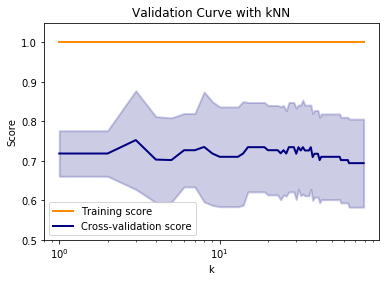

In [17]:
myModel2 = KNeighborsClassifier(weights="distance")
plot_validation_curve(myModel2, XTrain, yTrain, kVals, myCV3, 0.5, 1.05)

Introducing euclidean distance weights, we obtained a similar result in k number respect to the previously discussed as the likely best (k=3 here) and **training accuracy is improved up to 100% without jeopardizing the generalization ability of the algorithm**, as we can see in the **comparison between uniform and distance**:

| CV method | CV score | CV std | Train score  | Train std| Best k | Weights | Metric |
| --------- | --------:| ------:|-------------:| --------:| ------:| -------:|-------:|
| StratifiedKFold  | 0.75       | 0.1128    | 0.7365       |0.0149 |   23    | uniform |        |
| StratifiedKFold     | 0.75   | 0.125273      | 1       | 0 |   3    | distance | Euclidean |

> QUESTION 7) Following the same approach as in the previous question, introduce the type of distance ``metric`` in CV process. Evaluate the results and gain / losses of generalization capacity of the model.

Below several other distance metrics feasible for this dataset (real-valued vector space) are tested: 
- **manhattan** (distance function:  ``sum(|x - y|)``) 
- **chebyshev** (distance function:  ``max(|x - y|)``):

In [18]:
myParamGrid3 = {'n_neighbors': kVals,
               'weights': ['distance'],
               'metric':['manhattan', 'chebyshev']}

# Run GridSearch CV for the given inputs
myBestModel5 = runMyGridSearchCV(myModel, myParamGrid3, myCV3, XGrid, yGrid)

Fitting 10 folds for each of 158 candidates, totalling 1580 fits
[CV] n_neighbors=1, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=1, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=1, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=1, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=1, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=1, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=1, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=1, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=1, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=1, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=1, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=1, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=1, metric=manhattan, weights=distance ...............
[CV]  n_neig

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] n_neighbors=2, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=2, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=2, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=2, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=2, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=2, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=2, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=2, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=2, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=2, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=2, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=2, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=3, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=3, metric=manhattan, weights=distance, total=   0.0s
[CV] 

[CV]  n_neighbors=9, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=9, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=9, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=9, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=9, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=9, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=9, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=9, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=9, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=9, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=9, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=9, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=9, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=10, metric=manhattan, weights=distance ..............
[CV]  

[CV] n_neighbors=15, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=15, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=15, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=15, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=15, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=15, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=15, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=15, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=15, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=15, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=15, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=15, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=16, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=16, metric=manhattan, weights=distance, total=   0.0s

[CV] n_neighbors=21, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=21, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=22, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=22, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=22, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=22, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=22, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=22, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=22, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=22, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=22, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=22, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=22, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=22, metric=manhattan, weights=distance, total=   0.0s

[CV]  n_neighbors=28, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=28, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=28, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=28, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=28, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=28, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=28, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=28, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=28, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=28, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=28, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=28, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=28, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=28, metric=manhattan, weights=distance ..............

[CV]  n_neighbors=34, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=34, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=34, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=34, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=34, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=34, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=34, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=34, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=34, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=35, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=35, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=35, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=35, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=35, metric=manhattan, weights=distance ..............

[CV]  n_neighbors=40, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=40, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=40, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=40, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=40, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=41, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=41, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=41, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=41, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=41, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=41, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=41, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=41, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=41, metric=manhattan, weights=distance ..............

[CV]  n_neighbors=47, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=47, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=47, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=47, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=47, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=47, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=47, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=47, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=47, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=47, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=47, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=47, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=47, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=47, metric=manhattan, weights=distance ..............

[CV]  n_neighbors=53, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=53, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=53, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=53, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=53, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=53, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=53, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=53, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=53, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=53, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=53, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=53, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=53, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=53, metric=manhattan, weights=distance ..............

[CV]  n_neighbors=59, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=59, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=59, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=59, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=59, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=59, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=59, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=59, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=59, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=59, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=59, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=59, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=59, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=59, metric=manhattan, weights=distance ..............

[CV]  n_neighbors=65, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=65, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=65, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=65, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=65, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=65, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=65, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=66, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=66, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=66, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=66, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=66, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=66, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=66, metric=manhattan, weights=distance ..............

[CV] n_neighbors=72, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=72, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=72, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=72, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=72, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=72, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=72, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=72, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=72, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=72, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=72, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=72, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=72, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=72, metric=manhattan, weights=distance, total=   0.0s

[CV]  n_neighbors=78, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=78, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=78, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=78, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=78, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=78, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=78, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=78, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=78, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=78, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=78, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=78, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=78, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=78, metric=manhattan, weights=distance ..............

[CV]  n_neighbors=6, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=6, metric=chebyshev, weights=distance ...............
[CV]  n_neighbors=6, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=6, metric=chebyshev, weights=distance ...............
[CV]  n_neighbors=6, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=6, metric=chebyshev, weights=distance ...............
[CV]  n_neighbors=6, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=6, metric=chebyshev, weights=distance ...............
[CV]  n_neighbors=6, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=6, metric=chebyshev, weights=distance ...............
[CV]  n_neighbors=6, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=6, metric=chebyshev, weights=distance ...............
[CV]  n_neighbors=6, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=6, metric=chebyshev, weights=distance ...............
[CV]  

[CV]  n_neighbors=13, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=13, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=13, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=13, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=13, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=13, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=13, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=13, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=13, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=13, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=13, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=13, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=13, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=13, metric=chebyshev, weights=distance ..............

[CV]  n_neighbors=18, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=18, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=18, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=19, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=19, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=19, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=19, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=19, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=19, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=19, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=19, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=19, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=19, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=19, metric=chebyshev, weights=distance ..............

[CV]  n_neighbors=25, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=25, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=25, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=25, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=25, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=25, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=25, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=25, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=25, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=25, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=25, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=25, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=25, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=25, metric=chebyshev, weights=distance ..............

[CV] n_neighbors=31, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=31, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=32, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=32, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=32, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=32, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=32, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=32, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=32, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=32, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=32, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=32, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=32, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=32, metric=chebyshev, weights=distance, total=   0.0s

[CV]  n_neighbors=38, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=38, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=38, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=38, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=38, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=38, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=38, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=38, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=38, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=38, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=38, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=38, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=38, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=38, metric=chebyshev, weights=distance ..............

[CV]  n_neighbors=44, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=44, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=44, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=44, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=44, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=44, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=44, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=44, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=44, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=44, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=44, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=44, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=44, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=44, metric=chebyshev, weights=distance ..............

[CV]  n_neighbors=50, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=50, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=50, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=50, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=50, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=50, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=50, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=50, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=50, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=50, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=50, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=50, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=50, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=50, metric=chebyshev, weights=distance ..............

[CV] n_neighbors=55, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=55, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=56, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=56, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=56, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=56, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=56, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=56, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=56, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=56, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=56, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=56, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=56, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=56, metric=chebyshev, weights=distance, total=   0.0s

[CV] n_neighbors=62, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=62, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=62, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=62, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=62, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=62, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=62, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=62, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=62, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=62, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=62, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=62, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=63, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=63, metric=chebyshev, weights=distance, total=   0.0s

[CV] n_neighbors=68, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=68, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=68, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=68, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=69, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=69, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=69, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=69, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=69, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=69, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=69, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=69, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=69, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=69, metric=chebyshev, weights=distance, total=   0.0s

[CV]  n_neighbors=75, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=75, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=75, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=75, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=75, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=75, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=75, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=75, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=75, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=75, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=75, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=75, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=75, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=75, metric=chebyshev, weights=distance ..............

[Parallel(n_jobs=1)]: Done 1580 out of 1580 | elapsed:   26.9s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_metric,param_n_neighbors,param_weights,params,rank_test_score,split0_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.0013,0.0021,0.774194,1.0,manhattan,1,distance,"{u'n_neighbors': 1, u'metric': u'manhattan', u...",3,0.642857,...,0.750000,1.0,0.833333,1.0,0.666667,1.0,4.582868e-04,0.000300,0.088132,0.0
1,0.0012,0.0022,0.774194,1.0,manhattan,2,distance,"{u'n_neighbors': 2, u'metric': u'manhattan', u...",3,0.642857,...,0.750000,1.0,0.833333,1.0,0.666667,1.0,4.000187e-04,0.000400,0.088132,0.0
2,0.0015,0.0022,0.790323,1.0,manhattan,3,distance,"{u'n_neighbors': 3, u'metric': u'manhattan', u...",1,0.571429,...,0.916667,1.0,0.916667,1.0,0.833333,1.0,4.999399e-04,0.000400,0.140101,0.0
3,0.0015,0.0023,0.758065,1.0,manhattan,4,distance,"{u'n_neighbors': 4, u'metric': u'manhattan', u...",14,0.642857,...,0.916667,1.0,0.833333,1.0,0.833333,1.0,4.999399e-04,0.000640,0.105991,0.0
4,0.0013,0.0021,0.774194,1.0,manhattan,5,distance,"{u'n_neighbors': 5, u'metric': u'manhattan', u...",3,0.714286,...,0.833333,1.0,0.916667,1.0,0.750000,1.0,4.582868e-04,0.000300,0.096721,0.0
5,0.0017,0.0025,0.790323,1.0,manhattan,6,distance,"{u'n_neighbors': 6, u'metric': u'manhattan', u...",1,0.642857,...,0.833333,1.0,0.916667,1.0,0.833333,1.0,6.402809e-04,0.000500,0.103725,0.0
6,0.0018,0.0026,0.774194,1.0,manhattan,7,distance,"{u'n_neighbors': 7, u'metric': u'manhattan', u...",3,0.642857,...,0.833333,1.0,0.916667,1.0,0.750000,1.0,3.999829e-04,0.000490,0.100980,0.0
7,0.0018,0.0030,0.766129,1.0,manhattan,8,distance,"{u'n_neighbors': 8, u'metric': u'manhattan', u...",9,0.642857,...,0.833333,1.0,0.833333,1.0,0.666667,1.0,3.999829e-04,0.000775,0.111974,0.0
8,0.0016,0.0031,0.774194,1.0,manhattan,9,distance,"{u'n_neighbors': 9, u'metric': u'manhattan', u...",3,0.642857,...,0.833333,1.0,0.833333,1.0,0.666667,1.0,6.633128e-04,0.001446,0.119286,0.0
9,0.0017,0.0027,0.766129,1.0,manhattan,10,distance,"{u'n_neighbors': 10, u'metric': u'manhattan', ...",9,0.642857,...,0.833333,1.0,0.833333,1.0,0.750000,1.0,4.582504e-04,0.000900,0.144434,0.0


Best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')
Best grid cross-validation score: 0.790322580645


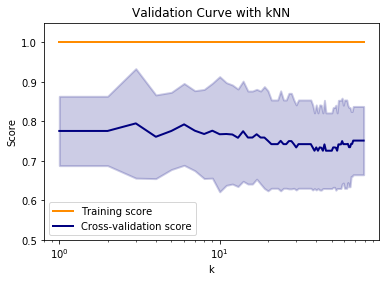

In [19]:
myModel3 = KNeighborsClassifier(weights="distance", metric="manhattan")
plot_validation_curve(myModel3, XTrain, yTrain, kVals, myCV3, 0.5, 1.05)

CV score obtained using ``manhattan`` distance metric was the highest among all the CV performed until now (0.79%) keeping the score at 100% as with euclidean distance, being also the standard deviation similar, so let's follow the rest of pending STEPS 5-7 with this Best Model.

| CV method | CV score | CV std | Train score  | Train std| Best k | Weights | Metric |
| --------- | --------:| ------:|-------------:| --------:| ------:| -------:|-------:|
| StratifiedKFold  | 0.75       | 0.1128    | 0.7365       |0.0149 |   23    | uniform |        |
| StratifiedKFold     | 0.75   | 0.125273      | 1       | 0 |   3    | distance | Euclidean |
| **StratifiedKFold**     | **0.7903 **  | **0.1401  **    |** 1   **    | **0 **|  ** 3 **   | **distance** |** Manhattan** |

## STEP 5: Fit the Best Model with XTrain, YTrain

In [20]:
# Fit model with Best estimator from step 3

myBestModel = myBestModel5
myBestModel.fit(XTrain, yTrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')

## STEP 6: Evaluate the score on XTest prediction

In [21]:
# Predict XTest using Best Estimator

yPred = myBestModel.predict(XTest)
yTrue = yTest

Below several metrics for quantifying the quality of the prediction are checked. The metrics below are some of the suitable metrics for binary targets, as it this is the case.

***- Accuracy score***

In [22]:
## Accuracy score
print("Accuracy score: " + str(accuracy_score(yTrue, yPred)))

Accuracy score: 0.759259259259


Accuracy score is slightly slower (76% vs 79%) but very similar to the validation score, so the best model is still consistent when applied to unseen data.

***- Classification report***

It shows the following scores for each class:

Precision = TP / (TP + FP)

Recall = TP (TP + FN)

f1-score = (2 · P · R) / (P + R)

In [23]:
# Classification report
print("CLASSIFICATION REPORT USING THE BEST ESTIMATOR:")
print(classification_report(yTrue, yPred))

CLASSIFICATION REPORT USING THE BEST ESTIMATOR:
             precision    recall  f1-score   support

        1.0       0.94      0.94      0.94        18
        2.0       0.73      0.76      0.74        21
        3.0       0.57      0.53      0.55        15

avg / total       0.76      0.76      0.76        54



Here we can see that even the average of misclassification error is 24%, precision and recall among the different classes is very different, being class 1 the best with a very high score and classes 2 and 3 the worst (PCA showed these two classes more mixed in the graph in fact).

***- Confusion matrix***

In [24]:
# Function to plot confusion matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

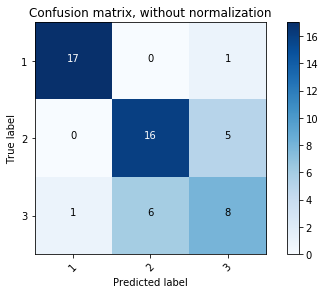

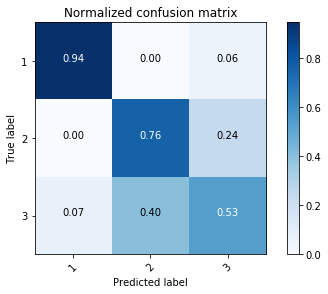

In [25]:
# Compute confusion matrix
confMatrix = confusion_matrix(yTrue, yPred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confMatrix, classes=targetNames, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(confMatrix, classes=targetNames, normalize=True, title='Normalized confusion matrix')

Confusion matrix provides a deeper knowledge about the previously discussed recall. Non-normalized graph shows support (number of samples in XTest) for TP, FP and FN and normalized shows it in percentages. 

Here the conclusion is the same, prediction for class 1 is very well performed. However, classes 3 and 2 are confused each other by the estimator in its predictions, being the worst case class 3, which has a 40% of misclassifications with class 2.

## STEP 7: CV with the complete dataset

Now that the estimator performed well in cross-validation and with unseen data (XTest), now it is time to check that taking the complete dataset and showing the estimator brand-new splits, it can be fit and predict accurately, and with low standard deviation between the splits. For that purpose, we can use ``cross_val_score`` function, with the inputs of the Best Estimator, (X,y) and a CV strategy:

In [26]:
# Cross-validation of the Best Estimator with the entire dataset
myStratifiedShuffleSplit = StratifiedShuffleSplit(100, 0.3, random_state = 42)
myCrosValScore = cross_val_score(myBestModel, X, y, cv=myStratifiedShuffleSplit)

print(myCrosValScore)
print ("Mean accuracy score: " + str(np.mean(myCrosValScore)))
print ("Std deviation: " + str(np.std(myCrosValScore)))

[ 0.76  0.74  0.81  0.74  0.74  0.8   0.7   0.72  0.78  0.8   0.85  0.85
  0.8   0.8   0.8   0.81  0.76  0.78  0.76  0.87  0.87  0.8   0.8   0.8
  0.83  0.8   0.74  0.74  0.8   0.67  0.83  0.8   0.85  0.85  0.74  0.74
  0.72  0.78  0.74  0.78  0.8   0.78  0.87  0.8   0.83  0.81  0.74  0.83
  0.72  0.72  0.74  0.76  0.81  0.85  0.78  0.85  0.83  0.72  0.81  0.74
  0.81  0.76  0.8   0.8   0.87  0.7   0.83  0.78  0.81  0.83  0.78  0.78
  0.69  0.87  0.85  0.72  0.76  0.78  0.78  0.83  0.8   0.8   0.78  0.81
  0.83  0.83  0.78  0.87  0.78  0.81  0.83  0.78  0.76  0.81  0.81  0.72
  0.76  0.81  0.78  0.7 ]
Mean accuracy score: 0.788518518519
Std deviation: 0.0459751826655


As showed, **estimator is still consistent when facing 100 new splits of the dataset**, with a mean score of 78,9 % and a low standard deviation between splits (4,6 %), scores similar to the ones obtained in CV and XTest prediction.

**Summary of the results**:

| (XTrain,yTrain)<br> CV score | (XTrain,yTrain)<br> CV std | (XTrain,yTrain)<br> Train score | (XTrain,yTrain) <br>Train std | Best k | Weights | metric | (XTest)<br> acc_score | (X,y)<br> mean_acc_score  | (X,y)<br> std_acc_score |
| -------- | --------:|-------------:| --------:| ------:| -------:| ---------:|---------:|---------:|
|0.7903   | 0.1401      | 1       | 0 |  3    | distance | Manhattan |0.7592  |0.7885 | 0.0459|

***- Decision boundaries***

We can plot the decision boundaries of the estimator to learn visually how it performs the classification:

Variance retention using 2 components: 99.9827146117 %


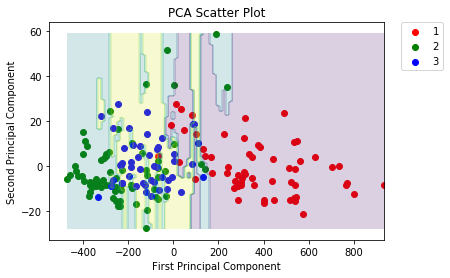

In [27]:
# Principal Component Analysis
myPCA = PCA(n_components = 2)
X_PCA = myPCA.fit_transform(X)

# Explained variance ratio
print ("Variance retention using 2 components: " + 
       str((np.sum(myPCA.fit(X).explained_variance_ratio_))*100) + " %")

# Plot PCA
colors = ['red', 'green', 'blue']

for i in range(len(colors)):
    xPlot = X_PCA[:, 0][y == i+1]
    yPlot = X_PCA[:, 1][y == i+1]
    plt.scatter(xPlot, yPlot, c=colors[i])
    plt.legend(targetNames, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("PCA Scatter Plot")

myBestModel.fit(X_PCA, y)

xx1, xx2 = np.meshgrid(np.linspace(X_PCA[:,0].min(),X_PCA[:,0].max(),100),np.linspace(X_PCA[:,1].min(),X_PCA[:,1].max(),100))

Z = myBestModel.predict(np.c_[xx1.ravel(), xx2.ravel()])
Z = Z.reshape(xx1.shape)

plt.contourf(xx1, xx2, Z, alpha=0.2)
plt.axis('tight')
plt.show()

Here we can see what we observed in classification report and confusion matrix, class 3 is misclassified with class 2 and viceversa, being the situation more critical in class 3 classifications.

***- Learning curve***

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

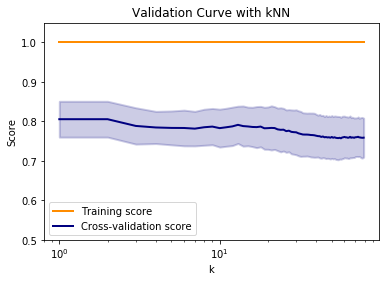

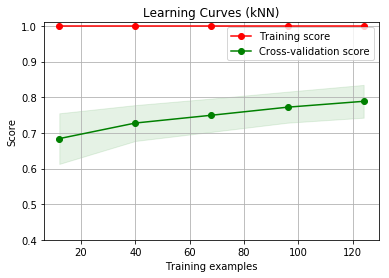

In [38]:
# Plot validation curve
myModel3 = KNeighborsClassifier(weights="distance", metric="manhattan")
plot_validation_curve(myModel3, X, y, kVals, myStratifiedShuffleSplit, 0.5, 1.05)

# Plot learning curve
title = "Learning Curves (kNN)"
plot_learning_curve(myBestModel, title, X, y, ylim=(0.4, 1.01), cv=myStratifiedShuffleSplit, n_jobs=4)

plt.show()

## Additional step: standardization

Another option found in the bibliography to improve the performance of the model could be to rescale the data using normalization (standardization), feed the standardized data to PCA for dimensional reduction and use its output as XTrain, XTest. Result of standardization is that the features will be rescaled so that they’ll have the properties of a standard normal distribution with μ=0 and σ=1 where μ is the mean (average) and σ is the standard deviation from the mean; standard scores (also called z scores) of the samples are calculated as follows: z=(x−μ)/σ [[7]](http://sebastianraschka.com/Articles/2014_about_feature_scaling.html#loading-the-wine-dataset). Please see Models benchmark for Wines dataset to see standarization process applied.